# Multiheaded TCN output

In [ ]:
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm
import holidays
import random

# --- Static Params ---
HISTORY_LEN = 48
PRED_HORIZON = 4
K_NEIGHBORS = 2
EPOCHS = 20
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_COMBINATIONS = 20
TRAIN_FRACTION = 0.01
EMBED_DIM = 8

# --- Load data ---
df = pd.read_csv('bicikelj_train.csv')
meta = pd.read_csv('bicikelj_metadata.csv')
station_cols = df.columns[1:]

# Clean and fill
for col in station_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[station_cols] = df[station_cols].ffill().bfill()
df = df.dropna(subset=station_cols, how='all').reset_index(drop=True)

# --- Station normalization ---
station_means = df[station_cols].mean()
station_stds = df[station_cols].std().replace(0, 1)
df_norm = df.copy()
df_norm[station_cols] = (df[station_cols] - station_means) / station_stds

# --- Neighbors ---
coords = np.deg2rad(meta[['latitude', 'longitude']].values)
station_names = meta['name'].tolist()
dists = haversine_distances(coords, coords) * 6371
neighbors = {}
for i, name in enumerate(station_names):
    order = np.argsort(dists[i])
    nn_idx = [j for j in order if j != i][:K_NEIGHBORS]
    neighbors[name] = [station_names[j] for j in nn_idx]

# --- Dataset ---
class SharedTCNDataset(Dataset):
    def __init__(self, df, station_cols, neighbors, history_len, pred_horizon):
        self.samples = []
        self.station_to_idx = {name: i for i, name in enumerate(station_cols)}
        timestamps = pd.to_datetime(df['timestamp'])

        hour_sin = np.sin(2 * np.pi * timestamps.dt.hour / 24)
        hour_cos = np.cos(2 * np.pi * timestamps.dt.hour / 24)
        dow_sin = np.sin(2 * np.pi * timestamps.dt.dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * timestamps.dt.dayofweek / 7)
        month_sin = np.sin(2 * np.pi * timestamps.dt.month / 12)
        month_cos = np.cos(2 * np.pi * timestamps.dt.month / 12)
        is_weekend = (timestamps.dt.dayofweek >= 5).astype(float)
        slo_holidays = holidays.Slovenia()
        is_holiday = timestamps.dt.date.astype(str).isin([str(d) for d in slo_holidays]).astype(float)
        time_feats = np.stack([hour_sin, hour_cos, dow_sin, dow_cos,
                               month_sin, month_cos, is_weekend, is_holiday], axis=1)

        bikes = df[station_cols].values.astype(np.float32)
        N = len(df)

        for s_name in station_cols:
            s_idx = self.station_to_idx[s_name]
            nn_idx = [self.station_to_idx[nn] for nn in neighbors[s_name]]
            series = bikes[:, [s_idx] + nn_idx]
            full_feats = np.concatenate([series, time_feats], axis=1)

            for i in range(history_len, N - pred_horizon + 1):
                x = full_feats[i - history_len:i]
                y = bikes[i:i + pred_horizon, s_idx]
                self.samples.append((x, y, s_idx))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        x, y, sid = self.samples[idx]
        return (torch.tensor(x, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32),
                torch.tensor(sid, dtype=torch.long))

# --- TCN block ---
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, :-self.padding]  # crop end
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)

        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, num_stations, embed_dim):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, dropout)]
        self.tcn = nn.Sequential(*layers)
        self.embedding = nn.Embedding(num_stations, embed_dim)

        # Multihead
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_channels[-1] + embed_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            ) for _ in range(output_size)
        ])

    def forward(self, x, station_id):
        x = x.permute(0, 2, 1)
        tcn_out = self.tcn(x)[:, :, -1]
        emb = self.embedding(station_id)
        combined = torch.cat([tcn_out, emb], dim=1)

        out = [head(combined) for head in self.heads]  # list of [B,1]
        out = torch.cat(out, dim=1)  # [B, PRED_HORIZON]
        return out


# --- Training ---
def train_tcn(model, train_loader, val_loader, lr, weight_decay):
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    best_loss = float('inf')
    best_state = None
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        for xb, yb, sid in train_loader:
            xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb, sid), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb, sid in val_loader:
                xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
                val_loss += criterion(model(xb, sid), yb).item()
        val_loss /= len(val_loader)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                break

    model.load_state_dict(best_state)
    return model, best_loss

# --- Grid search ---
param_grid = {
    'hidden_dim': [32, 64, 128],
    'dropout': [0.0, 0.1, 0.2],
    'lr': [1e-3, 5e-4, 2e-4],
    'weight_decay': [0.0, 1e-5, 1e-4]
    # 'hidden_dim': [64],
    # 'dropout': [0.2],
    # 'lr': [0.0005],
    # 'weight_decay': [0.0001]
}
param_combos = list(itertools.product(*param_grid.values()))
random.shuffle(param_combos)
param_combos = param_combos[:MAX_COMBINATIONS]

# --- Dataset ---
dataset = SharedTCNDataset(df_norm, station_cols, neighbors, HISTORY_LEN, PRED_HORIZON)
N = len(dataset)
reduced_N = int(N * TRAIN_FRACTION)
indices = list(range(N))
random.shuffle(indices)

train_size = int(reduced_N * 0.7)
val_size = int(reduced_N * 0.15)
holdout_size = reduced_N - train_size - val_size

train_set = Subset(dataset, indices[:train_size])
val_set = Subset(dataset, indices[train_size:train_size + val_size])
holdout_set = Subset(dataset, indices[train_size + val_size:train_size + val_size + holdout_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
holdout_loader = DataLoader(holdout_set, batch_size=64)

# --- Run ---
input_dim = 1 + K_NEIGHBORS + 8  # station + neighbors + time features
output_dim = PRED_HORIZON
num_stations = len(station_cols)

n_layers = 4

results = []
print(f"⏳ Running grid search over {len(param_combos)} combinations...")
for i, (hdim, dr, lr, wd) in enumerate(param_combos):
    print(f"\n🔍 Combo {i+1}: hidden_dim={hdim}, dropout={dr}, lr={lr}, weight_decay={wd}")
    model = TCN(input_size=input_dim,
                output_size=output_dim,
                #num_channels=[hdim] * 3,
                num_channels=[hdim] * n_layers,

                kernel_size=3,
                dropout=dr,
                num_stations=num_stations,
                embed_dim=EMBED_DIM)
    model, val_loss = train_tcn(model, train_loader, val_loader, lr, wd)

    model.eval()
    holdout_loss = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for xb, yb, sid in holdout_loader:
            xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
            holdout_loss += criterion(model(xb, sid), yb).item()
    holdout_loss /= len(holdout_loader)

    print(f"✅ Val Loss: {val_loss:.4f}, Holdout Loss: {holdout_loss:.4f}")
    results.append({
        "hidden_dim": hdim,
        "dropout": dr,
        "lr": lr,
        "weight_decay": wd,
        "val_loss": val_loss,
        "holdout_loss": holdout_loss
    })

# --- Save ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="holdout_loss")
results_df.to_csv("grid_search_tcn_results.csv", index=False)
print("\n📊 Top 5 Results:")
print(results_df.head())


⏳ Running grid search over 20 combinations...

🔍 Combo 1: hidden_dim=32, dropout=0.0, lr=0.0005, weight_decay=0.0001
✅ Val Loss: 0.3813, Holdout Loss: 0.4025

🔍 Combo 2: hidden_dim=64, dropout=0.1, lr=0.0002, weight_decay=0.0001
✅ Val Loss: 0.3615, Holdout Loss: 0.3727

🔍 Combo 3: hidden_dim=128, dropout=0.0, lr=0.0002, weight_decay=1e-05
✅ Val Loss: 0.3846, Holdout Loss: 0.4234

🔍 Combo 4: hidden_dim=64, dropout=0.1, lr=0.001, weight_decay=1e-05
✅ Val Loss: 0.3610, Holdout Loss: 0.3699

🔍 Combo 5: hidden_dim=64, dropout=0.2, lr=0.0005, weight_decay=1e-05
✅ Val Loss: 0.3588, Holdout Loss: 0.3673

🔍 Combo 6: hidden_dim=32, dropout=0.1, lr=0.001, weight_decay=0.0
✅ Val Loss: 0.3616, Holdout Loss: 0.3744

🔍 Combo 7: hidden_dim=128, dropout=0.2, lr=0.0005, weight_decay=0.0001
✅ Val Loss: 0.3616, Holdout Loss: 0.3730

🔍 Combo 8: hidden_dim=32, dropout=0.0, lr=0.001, weight_decay=0.0001


KeyboardInterrupt: 

# Weather

In [ ]:
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm
import holidays
import random

# --- Static Params ---
HISTORY_LEN = 48
PRED_HORIZON = 4
K_NEIGHBORS = 2
EPOCHS = 20
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_COMBINATIONS = 20
TRAIN_FRACTION = 0.01
EMBED_DIM = 8

# --- Load data ---
df = pd.read_csv('bicikelj_train.csv')
meta = pd.read_csv('bicikelj_metadata.csv')
station_cols = df.columns[1:]

# Clean and fill
for col in station_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[station_cols] = df[station_cols].ffill().bfill()
df = df.dropna(subset=station_cols, how='all').reset_index(drop=True)

# --- Load weather ---
# Load weather
weather_df = pd.read_csv("weather_ljubljana.csv", skiprows=2)
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_df['time'] = pd.to_datetime(weather_df['time'])

# Align timestamp formats
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)

# Merge
df_merged = pd.merge(df, weather_df, left_on='timestamp', right_on='time', how='left')


# Weather features to use
weather_features = ['temperature_2m', 'precipitation', 'windspeed_10m', 'cloudcover']
df_merged[weather_features] = df_merged[weather_features].ffill().bfill()

# Normalize station + weather
station_means = df_merged[station_cols].mean()
station_stds = df_merged[station_cols].std().replace(0, 1)
df_norm = df_merged.copy()
df_norm[station_cols] = (df_merged[station_cols] - station_means) / station_stds

weather_means = df_merged[weather_features].mean()
weather_stds = df_merged[weather_features].std().replace(0, 1)
df_norm[weather_features] = (df_merged[weather_features] - weather_means) / weather_stds

# --- Neighbors ---
coords = np.deg2rad(meta[['latitude', 'longitude']].values)
station_names = meta['name'].tolist()
dists = haversine_distances(coords, coords) * 6371
neighbors = {}
for i, name in enumerate(station_names):
    order = np.argsort(dists[i])
    nn_idx = [j for j in order if j != i][:K_NEIGHBORS]
    neighbors[name] = [station_names[j] for j in nn_idx]

# --- Dataset ---
class SharedTCNDataset(Dataset):
    def __init__(self, df, station_cols, neighbors, history_len, pred_horizon, weather_features):
        self.samples = []
        self.station_to_idx = {name: i for i, name in enumerate(station_cols)}
        timestamps = pd.to_datetime(df['timestamp'])

        hour_sin = np.sin(2 * np.pi * timestamps.dt.hour / 24)
        hour_cos = np.cos(2 * np.pi * timestamps.dt.hour / 24)
        dow_sin = np.sin(2 * np.pi * timestamps.dt.dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * timestamps.dt.dayofweek / 7)
        month_sin = np.sin(2 * np.pi * timestamps.dt.month / 12)
        month_cos = np.cos(2 * np.pi * timestamps.dt.month / 12)
        is_weekend = (timestamps.dt.dayofweek >= 5).astype(float)
        slo_holidays = holidays.Slovenia()
        is_holiday = timestamps.dt.date.astype(str).isin([str(d) for d in slo_holidays]).astype(float)

        weather_array = df[weather_features].values  # [N, W]

        time_feats = np.concatenate([
            np.stack([hour_sin, hour_cos, dow_sin, dow_cos,
                      month_sin, month_cos, is_weekend, is_holiday], axis=1),
            weather_array
        ], axis=1)  # [N, 8+W]

        bikes = df[station_cols].values.astype(np.float32)
        N = len(df)

        for s_name in station_cols:
            s_idx = self.station_to_idx[s_name]
            nn_idx = [self.station_to_idx[nn] for nn in neighbors[s_name]]
            series = bikes[:, [s_idx] + nn_idx]
            full_feats = np.concatenate([series, time_feats], axis=1)

            for i in range(history_len, N - pred_horizon + 1):
                x = full_feats[i - history_len:i]
                y = bikes[i:i + pred_horizon, s_idx]
                self.samples.append((x, y, s_idx))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        x, y, sid = self.samples[idx]
        return (torch.tensor(x, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32),
                torch.tensor(sid, dtype=torch.long))

# --- TCN block ---
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)

        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, num_stations, embed_dim):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, dropout)]
        self.tcn = nn.Sequential(*layers)
        self.embedding = nn.Embedding(num_stations, embed_dim)

        # Multihead:
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_channels[-1] + embed_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            ) for _ in range(output_size)
        ])

    def forward(self, x, station_id):
        x = x.permute(0, 2, 1)
        tcn_out = self.tcn(x)[:, :, -1]
        emb = self.embedding(station_id)
        combined = torch.cat([tcn_out, emb], dim=1)
        out = [head(combined) for head in self.heads]
        out = torch.cat(out, dim=1)
        return out

# --- Training ---
def train_tcn(model, train_loader, val_loader, lr, weight_decay):
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    best_loss = float('inf')
    best_state = None
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        for xb, yb, sid in train_loader:
            xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb, sid), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb, sid in val_loader:
                xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
                val_loss += criterion(model(xb, sid), yb).item()
        val_loss /= len(val_loader)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                break

    model.load_state_dict(best_state)
    return model, best_loss

# --- Grid search ---
param_grid = {
    'hidden_dim': [256, 512],
    'dropout': [0.5],
    'lr': [0.001],
    'weight_decay': [0.001]
}
# param_grid = {
#     'hidden_dim': [32, 64, 128, 256],
#     'dropout': [0.1, 0.2, 0.3, 0.5],
#     'lr': [0.001, 0.0005, 0.0001],
#     'weight_decay': [0.0, 0.00001, 0.0001, 0.001]
# }

param_combos = list(itertools.product(*param_grid.values()))
random.shuffle(param_combos)
param_combos = param_combos[:MAX_COMBINATIONS]

# --- Dataset ---
dataset = SharedTCNDataset(df_norm, station_cols, neighbors, HISTORY_LEN, PRED_HORIZON, weather_features)
N = len(dataset)
reduced_N = int(N * TRAIN_FRACTION)
indices = list(range(N))

train_size = int(reduced_N * 0.7)
val_size = int(reduced_N * 0.15)
holdout_size = reduced_N - train_size - val_size

train_set = Subset(dataset, indices[:train_size])
val_set = Subset(dataset, indices[train_size:train_size + val_size])
holdout_set = Subset(dataset, indices[train_size + val_size:train_size + val_size + holdout_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
holdout_loader = DataLoader(holdout_set, batch_size=64)

# --- Run ---
input_dim = 1 + K_NEIGHBORS + (8 + len(weather_features))
output_dim = PRED_HORIZON
num_stations = len(station_cols)
n_layers = 4

results = []
print(f"⏳ Running grid search over {len(param_combos)} combinations...")
for i, (hdim, dr, lr, wd) in enumerate(param_combos):
    print(f"\n🔍 Combo {i+1}: hidden_dim={hdim}, dropout={dr}, lr={lr}, weight_decay={wd}")
    model = TCN(input_size=input_dim,
                output_size=output_dim,
                num_channels=[hdim] * n_layers,
                kernel_size=3,
                dropout=dr,
                num_stations=num_stations,
                embed_dim=EMBED_DIM)
    model, val_loss = train_tcn(model, train_loader, val_loader, lr, wd)

    model.eval()
    holdout_loss = 0.0
    criterion = nn.MSELoss()
    # with torch.no_grad():
    #     for xb, yb, sid in holdout_loader:
    #         xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
    #         holdout_loss += criterion(model(xb, sid), yb).item()
    # holdout_loss /= len(holdout_loader)

    # print(f"✅ Val Loss: {val_loss:.4f}, Holdout Loss: {holdout_loss:.4f}")

    all_preds = []
    all_targets = []
    all_sids = []

    with torch.no_grad():
        for xb, yb, sid in holdout_loader:
            xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
            preds = model(xb, sid)
            preds = preds.cpu().numpy()
            yb = yb.cpu().numpy()
            sid = sid.cpu().numpy()
            for b in range(preds.shape[0]):
                s = sid[b]
                mean = station_means.iloc[s]
                std = station_stds.iloc[s]
                all_preds.append(preds[b] * std + mean)
                all_targets.append(yb[b] * std + mean)
    # Now compute MSE in real units:
    import numpy as np
    from sklearn.metrics import mean_squared_error
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    print("Holdout MSE (real units):", mean_squared_error(all_targets.flatten(), all_preds.flatten()))



    results.append({
        "hidden_dim": hdim,
        "dropout": dr,
        "lr": lr,
        "weight_decay": wd,
        "val_loss": val_loss,
        "holdout_loss": holdout_loss
    })

# --- Save ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="holdout_loss")
results_df.to_csv("grid_search_tcn_results.csv", index=False)
print("\n📊 Top 5 Results:")
print(results_df.head())


⏳ Running grid search over 2 combinations...

🔍 Combo 1: hidden_dim=512, dropout=0.5, lr=0.001, weight_decay=0.001


KeyboardInterrupt: 

# Combined weather

In [ ]:
# --- TCN Bicikelj final training + test prediction with weather ---

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm
import holidays
import random

# --- Hyperparameters ---
HISTORY_LEN = 48
PRED_HORIZON = 4
K_NEIGHBORS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EMBED_DIM = 8
HIDDEN_DIM = 64
N_LAYERS = 4
LR = 0.0005
WEIGHT_DECAY = 0.0001
DROPOUT = 0.2
EPOCHS = 50
PATIENCE = 8
BATCH_SIZE = 128

# --- Load data ---
df = pd.read_csv("bicikelj_train.csv")
meta = pd.read_csv("bicikelj_metadata.csv")
station_cols = df.columns[1:]

# Clean and fill
for col in station_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df[station_cols] = df[station_cols].ffill().bfill()
df = df.dropna(subset=station_cols, how='all').reset_index(drop=True)

# --- Load weather ---
weather_df = pd.read_csv("weather_ljubljana.csv", skiprows=2)
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_df['time'] = pd.to_datetime(weather_df['time'])
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
df_merged = pd.merge(df, weather_df, left_on='timestamp', right_on='time', how='left')

weather_features = ['temperature_2m', 'precipitation', 'windspeed_10m', 'cloudcover']
df_merged[weather_features] = df_merged[weather_features].ffill().bfill()

# --- Normalize ---
station_means = df_merged[station_cols].mean()
station_stds = df_merged[station_cols].std().replace(0, 1)
df_norm = df_merged.copy()
df_norm[station_cols] = (df_merged[station_cols] - station_means) / station_stds

weather_means = df_merged[weather_features].mean()
weather_stds = df_merged[weather_features].std().replace(0, 1)
df_norm[weather_features] = (df_merged[weather_features] - weather_means) / weather_stds

# --- Neighbors ---
coords = np.deg2rad(meta[['latitude', 'longitude']].values)
station_names = meta['name'].tolist()
dists = haversine_distances(coords, coords) * 6371
neighbors = {}
for i, name in enumerate(station_names):
    order = np.argsort(dists[i])
    nn_idx = [j for j in order if j != i][:K_NEIGHBORS]
    neighbors[name] = [station_names[j] for j in nn_idx]

# --- Dataset ---
class SharedTCNDataset(Dataset):
    def __init__(self, df, station_cols, neighbors, history_len, pred_horizon, weather_features):
        self.samples = []
        self.station_to_idx = {name: i for i, name in enumerate(station_cols)}
        timestamps = pd.to_datetime(df['timestamp'])

        hour_sin = np.sin(2 * np.pi * timestamps.dt.hour / 24)
        hour_cos = np.cos(2 * np.pi * timestamps.dt.hour / 24)
        dow_sin = np.sin(2 * np.pi * timestamps.dt.dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * timestamps.dt.dayofweek / 7)
        month_sin = np.sin(2 * np.pi * timestamps.dt.month / 12)
        month_cos = np.sin(2 * np.pi * timestamps.dt.month / 12)
        is_weekend = (timestamps.dt.dayofweek >= 5).astype(float)
        slo_holidays = holidays.Slovenia()
        is_holiday = timestamps.dt.date.astype(str).isin([str(d) for d in slo_holidays]).astype(float)

        weather_array = df[weather_features].values

        time_feats = np.concatenate([
            np.stack([hour_sin, hour_cos, dow_sin, dow_cos,
                      month_sin, month_cos, is_weekend, is_holiday], axis=1),
            weather_array
        ], axis=1)

        bikes = df[station_cols].values.astype(np.float32)
        N = len(df)

        for s_name in station_cols:
            s_idx = self.station_to_idx[s_name]
            nn_idx = [self.station_to_idx[nn] for nn in neighbors[s_name]]
            series = bikes[:, [s_idx] + nn_idx]
            full_feats = np.concatenate([series, time_feats], axis=1)

            for i in range(history_len, N - pred_horizon + 1):
                x = full_feats[i - history_len:i]
                y = bikes[i:i + pred_horizon, s_idx]
                self.samples.append((x, y, s_idx))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        x, y, sid = self.samples[idx]
        return (torch.tensor(x, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32),
                torch.tensor(sid, dtype=torch.long))

# --- TCN Block ---
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)

        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, num_stations, embed_dim):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, dropout)]
        self.tcn = nn.Sequential(*layers)
        self.embedding = nn.Embedding(num_stations, embed_dim)
        self.head = nn.Sequential(
            nn.Linear(num_channels[-1] + embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x, station_id):
        x = x.permute(0, 2, 1)
        tcn_out = self.tcn(x)[:, :, -1]
        emb = self.embedding(station_id)
        combined = torch.cat([tcn_out, emb], dim=1)
        return self.head(combined)


In [ ]:
# TRAIN
# --- Training ---
dataset = SharedTCNDataset(df_norm, station_cols, neighbors, HISTORY_LEN, PRED_HORIZON, weather_features)
N = len(dataset)
indices = list(range(N))

val_size = int(0.1 * N)
train_size = N - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

model = TCN(input_size=1 + K_NEIGHBORS + (8 + len(weather_features)),
            output_size=PRED_HORIZON,
            num_channels=[HIDDEN_DIM] * N_LAYERS,
            kernel_size=3,
            dropout=DROPOUT,
            num_stations=len(station_cols),
            embed_dim=EMBED_DIM).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()

best_loss = float('inf')
best_state = None
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for xb, yb, sid in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(xb, sid), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, sid in val_loader:
            xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
            val_loss += criterion(model(xb, sid), yb).item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping!")
            break

model.load_state_dict(best_state)
torch.save(model.state_dict(), "tcn_model_final_weather.pt")
print("✅ Saved model to 'tcn_model_final_weather.pt'")

Epoch 1/50: 100%|██████████| 12056/12056 [01:32<00:00, 130.88it/s]


Epoch 1: Train Loss = 0.3209
Epoch 1: Val Loss = 0.3550


Epoch 2/50: 100%|██████████| 12056/12056 [01:31<00:00, 131.25it/s]

Epoch 2: Train Loss = 0.2989


Epoch 2: Val Loss = 0.3629


Epoch 3/50: 100%|██████████| 12056/12056 [01:31<00:00, 131.46it/s]

Epoch 3: Train Loss = 0.2918


Epoch 3: Val Loss = 0.3631


Epoch 4/50: 100%|██████████| 12056/12056 [01:30<00:00, 133.55it/s]

Epoch 4: Train Loss = 0.2887


Epoch 4: Val Loss = 0.3700


Epoch 5/50: 100%|██████████| 12056/12056 [01:32<00:00, 130.35it/s]

Epoch 5: Train Loss = 0.2869


Epoch 5: Val Loss = 0.3747


Epoch 6/50: 100%|██████████| 12056/12056 [01:31<00:00, 131.47it/s]

Epoch 6: Train Loss = 0.2859


Epoch 6: Val Loss = 0.3787


Epoch 7/50:  76%|███████▌  | 9148/12056 [01:11<00:22, 127.31it/s]


KeyboardInterrupt: 

In [ ]:
# PREDICTION
# --- Load model ---
model = TCN(input_size=1 + K_NEIGHBORS + (8 + len(weather_features)),
            output_size=PRED_HORIZON,
            num_channels=[HIDDEN_DIM] * N_LAYERS,
            kernel_size=3,
            dropout=DROPOUT,
            num_stations=len(station_cols),
            embed_dim=EMBED_DIM).to(DEVICE)

model.load_state_dict(torch.load("tcn_model_final_weather.pt"))
model.eval()

# --- Load test set ---
test_df = pd.read_csv("bicikelj_test.csv")
test_feats = test_df[station_cols].values.astype(np.float32)
timestamps = pd.to_datetime(test_df["timestamp"])

# --- Load weather for test ---
weather_test_df = pd.read_csv("weather_ljubljana_test.csv", skiprows=2)
weather_test_df = weather_test_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_test_df['time'] = pd.to_datetime(weather_test_df['time'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp']).dt.tz_localize(None)
test_df_merged = pd.merge(test_df, weather_test_df, left_on='timestamp', right_on='time', how='left')
test_df_merged[weather_features] = test_df_merged[weather_features].ffill().bfill()

# --- Time features ---
hour_sin = np.sin(2 * np.pi * timestamps.dt.hour / 24)
hour_cos = np.cos(2 * np.pi * timestamps.dt.hour / 24)
dow_sin = np.sin(2 * np.pi * timestamps.dt.dayofweek / 7)
dow_cos = np.cos(2 * np.pi * timestamps.dt.dayofweek / 7)
month_sin = np.sin(2 * np.pi * timestamps.dt.month / 12)
month_cos = np.sin(2 * np.pi * timestamps.dt.month / 12)
is_weekend = (timestamps.dt.dayofweek >= 5).astype(float)
slo_holidays = holidays.Slovenia()
is_holiday = timestamps.dt.date.astype(str).isin([str(d) for d in slo_holidays]).astype(float)

time_feats = np.stack([hour_sin, hour_cos, dow_sin, dow_cos,
                       month_sin, month_cos, is_weekend, is_holiday], axis=1)

# --- Normalize test_feats and weather ---
test_feats_norm = (test_feats - station_means.values) / station_stds.values
weather_feats_norm = (test_df_merged[weather_features].values - weather_means.values) / weather_stds.values

# --- Predict ---
name_to_idx = {name: i for i, name in enumerate(station_cols)}
pred_matrix = np.full_like(test_feats, np.nan)

with torch.no_grad():
    for i in range(HISTORY_LEN, len(test_df) - PRED_HORIZON + 1):
        if np.isnan(test_feats[i:i + PRED_HORIZON]).all(axis=0).all():
            for station in station_cols:
                s_idx = name_to_idx[station]
                nn_idx = [name_to_idx[nn] for nn in neighbors[station]]

                seq = []
                for t in range(i - HISTORY_LEN, i):
                    row = [test_feats_norm[t, s_idx]]
                    row += [test_feats_norm[t, j] for j in nn_idx]
                    row += list(time_feats[t])
                    row += list(weather_feats_norm[t])
                    seq.append(row)

                seq = torch.tensor([seq], dtype=torch.float32).to(DEVICE)
                sid_tensor = torch.tensor([s_idx], dtype=torch.long, device=DEVICE)

                pred_norm = model(seq, sid_tensor).cpu().numpy().flatten()
                pred = pred_norm * station_stds[station] + station_means[station]

                for j in range(PRED_HORIZON):
                    pred_matrix[i + j, s_idx] = pred[j]

# --- Save predictions ---
pred_df = pd.DataFrame(pred_matrix, columns=station_cols)
pred_df.insert(0, "timestamp", test_df["timestamp"])

rows_to_output = test_df[station_cols].isna().all(axis=1)
pred_df_filtered = pred_df[rows_to_output].copy()

pred_df_filtered.to_csv("bicikelj_test_predictions_tcn_weather.csv", index=False)
print("✅ Saved predictions to 'bicikelj_test_predictions_tcn_weather.csv'")

✅ Saved predictions to 'bicikelj_test_predictions_tcn_weather.csv'


In [ ]:
import torch

# Save as checkpoint with normalization stats, as expected by the unified script
torch.save({
    'model': model.state_dict(),
    'station_means': station_means,
    'station_stds': station_stds,
    'weather_means': weather_means,
    'weather_stds': weather_stds
}, "tcn_model_final_with_stats.pt")
print("✅ Resaved model together with normalization statistics as 'tcn_model_final_with_stats.pt'")


✅ Resaved model together with normalization statistics as 'tcn_model_final_with_stats.pt'


# SHAP

In [ ]:
import numpy as np
import pandas as pd
import torch
import holidays
from sklearn.metrics.pairwise import haversine_distances

# --- Hyperparameters (should match those from your model!) ---
HISTORY_LEN = 48
PRED_HORIZON = 4
K_NEIGHBORS = 2

# --- Load metadata ---
meta = pd.read_csv("bicikelj_metadata.csv")
station_cols = pd.read_csv("bicikelj_train.csv").columns[1:]
station_names = meta['name'].tolist()

# --- Load weather (train, test) ---
weather_df = pd.read_csv("weather_ljubljana.csv", skiprows=2)
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_features = ['temperature_2m', 'precipitation', 'windspeed_10m', 'cloudcover']

weather_test_df = pd.read_csv("weather_ljubljana_test.csv", skiprows=2)
weather_test_df = weather_test_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_test_df['time'] = pd.to_datetime(weather_test_df['time'])

# --- Load train for mean/std (needed for normalization) ---
df_train = pd.read_csv("bicikelj_train.csv")
for col in station_cols:
    df_train[col] = pd.to_numeric(df_train[col], errors="coerce")
df_train[station_cols] = df_train[station_cols].ffill().bfill()
df_train = df_train.dropna(subset=station_cols, how='all').reset_index(drop=True)
df_train['timestamp'] = pd.to_datetime(df_train['timestamp']).dt.tz_localize(None)

df_train_merged = pd.merge(df_train, weather_df, left_on='timestamp', right_on='time', how='left')
df_train_merged[weather_features] = df_train_merged[weather_features].ffill().bfill()

station_means = df_train_merged[station_cols].mean()
station_stds = df_train_merged[station_cols].std().replace(0, 1)
weather_means = df_train_merged[weather_features].mean()
weather_stds = df_train_merged[weather_features].std().replace(0, 1)

# --- Load and prep test set ---
df_test = pd.read_csv("bicikelj_test.csv")
for col in station_cols:
    df_test[col] = pd.to_numeric(df_test[col], errors="coerce")
df_test[station_cols] = df_test[station_cols].ffill().bfill()
df_test = df_test.dropna(subset=station_cols, how='all').reset_index(drop=True)
df_test['timestamp'] = pd.to_datetime(df_test['timestamp']).dt.tz_localize(None)

df_test_merged = pd.merge(df_test, weather_test_df, left_on='timestamp', right_on='time', how='left')
df_test_merged[weather_features] = df_test_merged[weather_features].ffill().bfill()

# --- Normalize test set using TRAIN stats ---
df_test_norm = df_test_merged.copy()
df_test_norm[station_cols] = (df_test_merged[station_cols] - station_means) / station_stds
df_test_norm[weather_features] = (df_test_merged[weather_features] - weather_means) / weather_stds

# --- Prepare neighbors dict (for input features) ---
coords = np.deg2rad(meta[['latitude', 'longitude']].values)
dists = haversine_distances(coords, coords) * 6371
neighbors = {}
for i, name in enumerate(station_names):
    order = np.argsort(dists[i])
    nn_idx = [j for j in order if j != i][:K_NEIGHBORS]
    neighbors[name] = [station_names[j] for j in nn_idx]

print("Test dataset and weather loaded, normalized, and ready.")


Test dataset and weather loaded, normalized, and ready.


In [ ]:
model = TCN(
    input_size=(1 + K_NEIGHBORS + 8 + len(weather_features)),  # features per timestep
    output_size=PRED_HORIZON,
    num_channels=[HIDDEN_DIM] * N_LAYERS,
    kernel_size=3,
    dropout=DROPOUT,
    num_stations=len(station_cols),
    embed_dim=EMBED_DIM
)
model.load_state_dict(torch.load("tcn_model_final_weather.pt", map_location=DEVICE))
model.eval()
model.to(DEVICE)

TCN(
  (tcn): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(15, 64, kernel_size=(3,), stride=(1,), padding=(2,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
      (downsample): Conv1d(15, 64, kernel_size=(1,), stride=(1,))
    )
    (1): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (relu): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
      (relu): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (3): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dila

In [ ]:
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt

# --------- SETTINGS ---------
N_BACKGROUND_PER_STATION = 5  # Number of background samples per station for SHAP
PERCENT_PER_STATION = 0.01     # Percentage of test samples per station to use for SHAP explanation (e.g. 0.2 means 20%)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------- PREPARE X_samples, SID_samples FROM TEST SET ---------
# (Assumes you loaded and normalized df_test_norm, have station_cols, weather_features, neighbors, etc.)

timestamps = pd.to_datetime(df_test_norm['timestamp'])
hour_sin = np.sin(2 * np.pi * timestamps.dt.hour / 24)
hour_cos = np.cos(2 * np.pi * timestamps.dt.hour / 24)
dow_sin = np.sin(2 * np.pi * timestamps.dt.dayofweek / 7)
dow_cos = np.cos(2 * np.pi * timestamps.dt.dayofweek / 7)
month_sin = np.sin(2 * np.pi * timestamps.dt.month / 12)
month_cos = np.cos(2 * np.pi * timestamps.dt.month / 12)
is_weekend = (timestamps.dt.dayofweek >= 5).astype(float)
slo_holidays = holidays.Slovenia()
is_holiday = timestamps.dt.date.astype(str).isin([str(d) for d in slo_holidays]).astype(float)

time_feats_arr = np.stack([hour_sin, hour_cos, dow_sin, dow_cos,
                           month_sin, month_cos, is_weekend, is_holiday], axis=1)
bikes = df_test_norm[station_cols].values.astype(np.float32)
weather_arr = df_test_norm[weather_features].values.astype(np.float32)

X_samples = []
SID_samples = []

N = len(df_test_norm)
station_to_idx = {name: i for i, name in enumerate(station_cols)}
for s_name in station_cols:
    s_idx = station_to_idx[s_name]
    nn_idx = [station_to_idx[nn] for nn in neighbors[s_name]]
    series = bikes[:, [s_idx] + nn_idx]
    full_feats = np.concatenate([series, time_feats_arr, weather_arr], axis=1)
    for i in range(HISTORY_LEN, N - PRED_HORIZON + 1):
        x_seq = full_feats[i - HISTORY_LEN:i]
        X_samples.append(x_seq)
        SID_samples.append(s_idx)

X_samples = torch.tensor(np.stack(X_samples), dtype=torch.float32)
SID_samples = torch.tensor(SID_samples, dtype=torch.long)

# --------- FEATURE NAMES ---------
n_neighbors = K_NEIGHBORS
feature_names_per_step = (
    ['station_value'] +
    [f'neighbor_{i+1}' for i in range(n_neighbors)] +
    ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_holiday'] +
    weather_features
)
NUM_STEP_FEATURES = len(feature_names_per_step)

flat_feature_names = []
for t in range(HISTORY_LEN):
    for fname in feature_names_per_step:
        flat_feature_names.append(f"{fname}_t-{HISTORY_LEN-t}")
flat_feature_names.append("station_id")

def flatten_sid(xs, sids):
    flat_xs = xs.reshape(xs.shape[0], -1)
    flat = np.concatenate([flat_xs, sids.reshape(-1, 1)], axis=1)
    return flat

# --------- STATION-BALANCED SAMPLING ---------
station_indices = {sid: [] for sid in range(len(station_cols))}
for i, sid in enumerate(SID_samples):
    station_indices[int(sid.item() if torch.is_tensor(sid) else sid)].append(i)

explain_idxs = []
background_idxs = []
for sid, idxs in station_indices.items():
    n = len(idxs)
    if n == 0:
        continue
    # Explanation: randomly sample PERCENT_PER_STATION for SHAP explanations
    n_explain = max(1, int(n * PERCENT_PER_STATION))
    chosen_explain = np.random.choice(idxs, size=n_explain, replace=False)
    explain_idxs.extend(chosen_explain)
    # Background: randomly sample N_BACKGROUND_PER_STATION for SHAP background
    chosen_background = np.random.choice(idxs, size=min(N_BACKGROUND_PER_STATION, n), replace=False)
    background_idxs.extend(chosen_background)

print("\nNumber of explanation samples per station:")
for sid, idxs in station_indices.items():
    n = len(idxs)
    n_explain = max(1, int(n * PERCENT_PER_STATION)) if n > 0 else 0
    print(f"  Station {sid:>2}: {n_explain} explanation samples from {n} total samples")
print(f"Total explanation samples: {len(explain_idxs)}")
print(f"Total background samples:   {len(background_idxs)}")


# --------- PREPARE EXPLAIN/BACKGROUND MATRICES ---------
explain_x = X_samples[explain_idxs].cpu().numpy()
explain_sid = SID_samples[explain_idxs].cpu().numpy()
full_explain = flatten_sid(explain_x, explain_sid)

background_x = X_samples[background_idxs].cpu().numpy()
background_sid = SID_samples[background_idxs].cpu().numpy()
full_background = flatten_sid(background_x, background_sid)

# --------- MODEL WRAPPER FOR SHAP ---------
def model_predict_flat(x):
    n_feat = NUM_STEP_FEATURES
    seq_len = HISTORY_LEN
    features = x[:, :seq_len * n_feat].reshape(-1, seq_len, n_feat)
    sids = x[:, -1].astype(np.int64)
    t = torch.tensor(features, dtype=torch.float32).to(DEVICE)
    sid = torch.tensor(sids, dtype=torch.long).to(DEVICE)
    with torch.no_grad():
        return model(t, sid).cpu().numpy()  # (batch, PRED_HORIZON)

# --------- SHAP EXPLAINER ---------
background_kmeans = shap.kmeans(full_background, 3)
explainer = shap.KernelExplainer(model_predict_flat, background_kmeans)

#explainer = shap.KernelExplainer(model_predict_flat, full_background)
shap_values = explainer.shap_values(full_explain)  # list: (N_EXPLAIN, N_FEATURES) for each output horizon


Number of explanation samples per station:
  Station  0: 15 explanation samples from 1509 total samples
  Station  1: 15 explanation samples from 1509 total samples
  Station  2: 15 explanation samples from 1509 total samples
  Station  3: 15 explanation samples from 1509 total samples
  Station  4: 15 explanation samples from 1509 total samples
  Station  5: 15 explanation samples from 1509 total samples
  Station  6: 15 explanation samples from 1509 total samples
  Station  7: 15 explanation samples from 1509 total samples
  Station  8: 15 explanation samples from 1509 total samples
  Station  9: 15 explanation samples from 1509 total samples
  Station 10: 15 explanation samples from 1509 total samples
  Station 11: 15 explanation samples from 1509 total samples
  Station 12: 15 explanation samples from 1509 total samples
  Station 13: 15 explanation samples from 1509 total samples
  Station 14: 15 explanation samples from 1509 total samples
  Station 15: 15 explanation samples from

  0%|          | 0/1260 [00:00<?, ?it/s]

shap_array shape: (1260, 721, 4)
mean_shap_vals_flat shape: (721,)


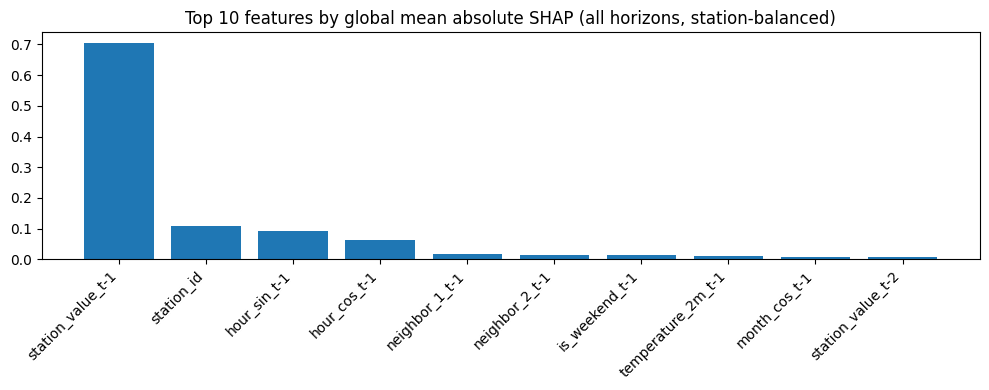

In [ ]:
# Aggregate list of (N_FEATURES, N_HORIZON) arrays into (N_EXPLAIN, N_FEATURES, N_HORIZON)
shap_array = np.stack(shap_values, axis=0)  # shape: (N_EXPLAIN, N_FEATURES, N_HORIZON)
print("shap_array shape:", shap_array.shape)  # should be (N_EXPLAIN, N_FEATURES, N_HORIZON)

# Global mean absolute SHAP value for each feature, averaged over samples and horizons
mean_shap_vals_flat = np.mean(np.abs(shap_array), axis=(0, 2))  # shape: (N_FEATURES,)
print("mean_shap_vals_flat shape:", mean_shap_vals_flat.shape)

# Top 10
top10_idx = np.argsort(mean_shap_vals_flat)[-10:][::-1]
top10_vals = mean_shap_vals_flat[top10_idx]
top10_names = [flat_feature_names[i] for i in top10_idx]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.bar(range(10), top10_vals)
plt.xticks(range(10), top10_names, rotation=45, ha='right', fontsize=10)
plt.title("Top 10 features by global mean absolute SHAP (all horizons, station-balanced)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Save shap_array, full_explain (your feature matrix), and flat_feature_names
np.savez("shap_output_testset.npz",
         shap_array=shap_array,  # (N_EXPLAIN, N_FEATURES, N_HORIZONS)
         full_explain=full_explain,  # (N_EXPLAIN, N_FLAT_FEATURES)
         flat_feature_names=np.array(flat_feature_names))


# Without normalization

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm
import holidays
import random

# --- Hyperparameters ---
HISTORY_LEN = 48
PRED_HORIZON = 4
K_NEIGHBORS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EMBED_DIM = 8
HIDDEN_DIM = 64
N_LAYERS = 4
LR = 0.0005
WEIGHT_DECAY = 0.0001
DROPOUT = 0.2
EPOCHS = 50
PATIENCE = 8
BATCH_SIZE = 128
VAL_FRAC = 0.1
STRIDE = 3  # Or whatever stride you want

# --- Load data ---
df = pd.read_csv("bicikelj_train.csv")
meta = pd.read_csv("bicikelj_metadata.csv")
station_cols = df.columns[1:]

# Clean and fill
for col in station_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df[station_cols] = df[station_cols].ffill().bfill()
df = df.dropna(subset=station_cols, how='all').reset_index(drop=True)

# --- Load weather ---
weather_df = pd.read_csv("weather_ljubljana.csv", skiprows=2)
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_df['time'] = pd.to_datetime(weather_df['time'])
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
df_merged = pd.merge(df, weather_df, left_on='timestamp', right_on='time', how='left')
weather_features = ['temperature_2m', 'precipitation', 'windspeed_10m', 'cloudcover']
df_merged[weather_features] = df_merged[weather_features].ffill().bfill()
N = len(df_merged)

# --- Randomly select validation cut regions ---
BLOCK_SIZE = HISTORY_LEN + PRED_HORIZON
np.random.seed(42)
all_possible_starts = np.arange(0, N - BLOCK_SIZE + 1)
val_mask = np.zeros(N, dtype=bool)
val_starts = []
target_val_coverage = int(VAL_FRAC * N)
covered = 0

np.random.shuffle(all_possible_starts)
for start in all_possible_starts:
    if val_mask[start:start + BLOCK_SIZE].any():
        continue  # Skip if this region overlaps with any already taken
    val_mask[start:start + BLOCK_SIZE] = True
    val_starts.append(start)
    covered += BLOCK_SIZE
    if covered >= target_val_coverage:
        break

train_mask = ~val_mask

print(f"Validation coverage: {val_mask.sum()} ({val_mask.sum()/N:.3f})")
print(f"Train coverage:      {train_mask.sum()} ({train_mask.sum()/N:.3f})")
print(f"Number of val sequences: {len(val_starts)}")

# --- Strided window sample selection ---
def make_sample_indices(mask, history_len, pred_horizon, stride=1):
    N = len(mask)
    indices = []
    for i in range(history_len, N - pred_horizon + 1, stride):
        if mask[i - history_len:i + pred_horizon].all():
            indices.append(i)
    return indices

train_indices = make_sample_indices(train_mask, HISTORY_LEN, PRED_HORIZON, stride=STRIDE)
val_indices = make_sample_indices(val_mask, HISTORY_LEN, PRED_HORIZON, stride=1)

print(f"Train samples: {len(train_indices)} | Val samples: {len(val_indices)}")

# --- Neighbors ---
coords = np.deg2rad(meta[['latitude', 'longitude']].values)
station_names = meta['name'].tolist()
dists = haversine_distances(coords, coords) * 6371
neighbors = {}
for i, name in enumerate(station_names):
    order = np.argsort(dists[i])
    nn_idx = [j for j in order if j != i][:K_NEIGHBORS]
    neighbors[name] = [station_names[j] for j in nn_idx]

# --- Dataset ---
class SharedTCNDataset(Dataset):
    def __init__(self, df, station_cols, neighbors, history_len, pred_horizon, weather_features, sample_indices):
        self.samples = []
        self.station_to_idx = {name: i for i, name in enumerate(station_cols)}
        timestamps = pd.to_datetime(df['timestamp'])
        hour_sin = np.sin(2 * np.pi * timestamps.dt.hour / 24)
        hour_cos = np.cos(2 * np.pi * timestamps.dt.hour / 24)
        dow_sin = np.sin(2 * np.pi * timestamps.dt.dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * timestamps.dt.dayofweek / 7)
        month_sin = np.sin(2 * np.pi * timestamps.dt.month / 12)
        month_cos = np.cos(2 * np.pi * timestamps.dt.month / 12)
        is_weekend = (timestamps.dt.dayofweek >= 5).astype(float)
        slo_holidays = holidays.Slovenia()
        is_holiday = timestamps.dt.date.astype(str).isin([str(d) for d in slo_holidays]).astype(float)
        weather_array = df[weather_features].values
        time_feats = np.concatenate([
            np.stack([hour_sin, hour_cos, dow_sin, dow_cos,
                      month_sin, month_cos, is_weekend, is_holiday], axis=1),
            weather_array
        ], axis=1)
        bikes = df[station_cols].values.astype(np.float32)
        N = len(df)
        for s_name in station_cols:
            s_idx = self.station_to_idx[s_name]
            nn_idx = [self.station_to_idx[nn] for nn in neighbors[s_name]]
            series = bikes[:, [s_idx] + nn_idx]
            full_feats = np.concatenate([series, time_feats], axis=1)
            for i in sample_indices:
                x = full_feats[i - history_len:i]
                y = bikes[i:i + pred_horizon, s_idx]
                self.samples.append((x, y, s_idx))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        x, y, sid = self.samples[idx]
        return (torch.tensor(x, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32),
                torch.tensor(sid, dtype=torch.long))

# --- TCN Block ---
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, num_stations, embed_dim):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, dropout)]
        self.tcn = nn.Sequential(*layers)
        self.embedding = nn.Embedding(num_stations, embed_dim)
        self.head = nn.Sequential(
            nn.Linear(num_channels[-1] + embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    def forward(self, x, station_id):
        x = x.permute(0, 2, 1)
        tcn_out = self.tcn(x)[:, :, -1]
        emb = self.embedding(station_id)
        combined = torch.cat([tcn_out, emb], dim=1)
        return self.head(combined)

# --- Prepare datasets and loaders ---
train_dataset = SharedTCNDataset(df_merged, station_cols, neighbors, HISTORY_LEN, PRED_HORIZON, weather_features, train_indices)
val_dataset   = SharedTCNDataset(df_merged, station_cols, neighbors, HISTORY_LEN, PRED_HORIZON, weather_features, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")

# --- Training ---
model = TCN(input_size=1 + K_NEIGHBORS + (8 + len(weather_features)),
            output_size=PRED_HORIZON,
            num_channels=[HIDDEN_DIM] * N_LAYERS,
            kernel_size=3,
            dropout=DROPOUT,
            num_stations=len(station_cols),
            embed_dim=EMBED_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()
best_loss = float('inf')
best_state = None
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for xb, yb, sid in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(xb, sid), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, sid in val_loader:
            xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
            val_loss += criterion(model(xb, sid), yb).item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f}")
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping!")
            break

model.load_state_dict(best_state)
torch.save(model.state_dict(), "tcn_model_final_weather.pt")
print("✅ Saved model to 'tcn_model_final_weather.pt'")

# --- OPTIONAL: For Colab: Download model
try:
    from google.colab import files
    files.download('tcn_model_final_weather.pt')
except:
    pass


Validation coverage: 2080 (0.102)
Train coverage:      18383 (0.898)
Number of val sequences: 40
Train samples: 5505 | Val samples: 40
Train samples: 462420 | Val samples: 3360


Epoch 1/50: 100%|██████████| 3613/3613 [00:27<00:00, 130.12it/s]

Epoch 1: Train Loss = 12.0140


Epoch 1: Val Loss = 10.7200


Epoch 2/50: 100%|██████████| 3613/3613 [00:28<00:00, 127.05it/s]

Epoch 2: Train Loss = 10.6227


Epoch 2: Val Loss = 10.2263


Epoch 3/50: 100%|██████████| 3613/3613 [00:27<00:00, 129.39it/s]

Epoch 3: Train Loss = 10.2437


Epoch 3: Val Loss = 10.1012


Epoch 4/50: 100%|██████████| 3613/3613 [00:28<00:00, 126.90it/s]

Epoch 4: Train Loss = 10.0018


Epoch 4: Val Loss = 9.9808


Epoch 5/50: 100%|██████████| 3613/3613 [00:27<00:00, 131.75it/s]

Epoch 5: Train Loss = 9.7933


Epoch 5: Val Loss = 10.0080


Epoch 6/50: 100%|██████████| 3613/3613 [00:28<00:00, 125.52it/s]


Epoch 6: Train Loss = 9.5741
Epoch 6: Val Loss = 9.7748


Epoch 7/50: 100%|██████████| 3613/3613 [00:27<00:00, 129.36it/s]

Epoch 7: Train Loss = 9.4125


Epoch 7: Val Loss = 9.6956


Epoch 8/50: 100%|██████████| 3613/3613 [00:29<00:00, 123.79it/s]

Epoch 8: Train Loss = 9.2897


Epoch 8: Val Loss = 9.6552


Epoch 9/50: 100%|██████████| 3613/3613 [00:27<00:00, 130.48it/s]

Epoch 9: Train Loss = 9.2040


Epoch 9: Val Loss = 9.5740


Epoch 10/50: 100%|██████████| 3613/3613 [00:28<00:00, 126.46it/s]

Epoch 10: Train Loss = 9.1360


Epoch 10: Val Loss = 9.6279


Epoch 11/50: 100%|██████████| 3613/3613 [00:27<00:00, 131.29it/s]

Epoch 11: Train Loss = 9.0821


Epoch 11: Val Loss = 9.5731


Epoch 12/50: 100%|██████████| 3613/3613 [00:27<00:00, 130.46it/s]

Epoch 12: Train Loss = 9.0308


Epoch 12: Val Loss = 9.5700


Epoch 13/50: 100%|██████████| 3613/3613 [00:27<00:00, 129.47it/s]

Epoch 13: Train Loss = 8.9934


Epoch 13: Val Loss = 9.5101


Epoch 14/50: 100%|██████████| 3613/3613 [00:27<00:00, 129.60it/s]

Epoch 14: Train Loss = 8.9433


Epoch 14: Val Loss = 9.5535


Epoch 15/50: 100%|██████████| 3613/3613 [00:28<00:00, 128.12it/s]

Epoch 15: Train Loss = 8.9148


Epoch 15: Val Loss = 9.6212


Epoch 16/50: 100%|██████████| 3613/3613 [00:28<00:00, 127.54it/s]

Epoch 16: Train Loss = 8.8860


Epoch 16: Val Loss = 9.4088


Epoch 17/50: 100%|██████████| 3613/3613 [00:27<00:00, 130.34it/s]

Epoch 17: Train Loss = 8.8521


Epoch 17: Val Loss = 9.4157


Epoch 18/50: 100%|██████████| 3613/3613 [00:28<00:00, 128.57it/s]

Epoch 18: Train Loss = 8.8307


Epoch 18: Val Loss = 9.5351


Epoch 19/50: 100%|██████████| 3613/3613 [00:28<00:00, 125.36it/s]

Epoch 19: Train Loss = 8.8103


Epoch 19: Val Loss = 9.5371


Epoch 20/50: 100%|██████████| 3613/3613 [00:28<00:00, 127.72it/s]

Epoch 20: Train Loss = 8.7838


Epoch 20: Val Loss = 9.6371


Epoch 21/50: 100%|██████████| 3613/3613 [00:27<00:00, 130.34it/s]

Epoch 21: Train Loss = 8.7672


Epoch 21: Val Loss = 9.6488


Epoch 22/50: 100%|██████████| 3613/3613 [00:28<00:00, 127.62it/s]

Epoch 22: Train Loss = 8.7440


Epoch 22: Val Loss = 9.5931


Epoch 23/50: 100%|██████████| 3613/3613 [00:28<00:00, 128.97it/s]

Epoch 23: Train Loss = 8.7267


Epoch 23: Val Loss = 9.6640


Epoch 24/50: 100%|██████████| 3613/3613 [00:27<00:00, 129.37it/s]

Epoch 24: Train Loss = 8.7121


Epoch 24: Val Loss = 9.5541
Early stopping!
✅ Saved model to 'tcn_model_final_weather.pt'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
import torch
import holidays

# --- Hyperparameters (must match training) ---
HISTORY_LEN = 48
PRED_HORIZON = 4
K_NEIGHBORS = 2
EMBED_DIM = 8
HIDDEN_DIM = 64
N_LAYERS = 4
DROPOUT = 0.2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

station_cols = pd.read_csv("bicikelj_train.csv").columns[1:]
weather_features = ['temperature_2m', 'precipitation', 'windspeed_10m', 'cloudcover']

# --- Neighbors ---
meta = pd.read_csv("bicikelj_metadata.csv")
coords = np.deg2rad(meta[['latitude', 'longitude']].values)
station_names = meta['name'].tolist()
from sklearn.metrics.pairwise import haversine_distances
dists = haversine_distances(coords, coords) * 6371
neighbors = {}
for i, name in enumerate(station_names):
    order = np.argsort(dists[i])
    nn_idx = [j for j in order if j != i][:K_NEIGHBORS]
    neighbors[name] = [station_names[j] for j in nn_idx]

# --- Model (identical architecture as training) ---
import torch.nn as nn
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, num_stations, embed_dim):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, dropout)]
        self.tcn = nn.Sequential(*layers)
        self.embedding = nn.Embedding(num_stations, embed_dim)
        self.head = nn.Sequential(
            nn.Linear(num_channels[-1] + embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    def forward(self, x, station_id):
        x = x.permute(0, 2, 1)
        tcn_out = self.tcn(x)[:, :, -1]
        emb = self.embedding(station_id)
        combined = torch.cat([tcn_out, emb], dim=1)
        return self.head(combined)

# --- Load model ---
model = TCN(
    input_size=1 + K_NEIGHBORS + (8 + len(weather_features)),
    output_size=PRED_HORIZON,
    num_channels=[HIDDEN_DIM] * N_LAYERS,
    kernel_size=3,
    dropout=DROPOUT,
    num_stations=len(station_cols),
    embed_dim=EMBED_DIM
).to(DEVICE)
model.load_state_dict(torch.load("tcn_model_final_weather.pt", map_location=DEVICE))
model.eval()

# --- Load test set ---
test_df = pd.read_csv("bicikelj_test.csv")
test_feats = test_df[station_cols].values.astype(np.float32)
timestamps = pd.to_datetime(test_df["timestamp"])

# --- Load weather for test ---
weather_test_df = pd.read_csv("weather_ljubljana_test.csv", skiprows=2)
weather_test_df = weather_test_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_test_df['time'] = pd.to_datetime(weather_test_df['time'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp']).dt.tz_localize(None)
test_df_merged = pd.merge(test_df, weather_test_df, left_on='timestamp', right_on='time', how='left')
test_df_merged[weather_features] = test_df_merged[weather_features].ffill().bfill()

# --- Time features ---
hour_sin = np.sin(2 * np.pi * timestamps.dt.hour / 24)
hour_cos = np.cos(2 * np.pi * timestamps.dt.hour / 24)
dow_sin = np.sin(2 * np.pi * timestamps.dt.dayofweek / 7)
dow_cos = np.cos(2 * np.pi * timestamps.dt.dayofweek / 7)
month_sin = np.sin(2 * np.pi * timestamps.dt.month / 12)
month_cos = np.sin(2 * np.pi * timestamps.dt.month / 12)
is_weekend = (timestamps.dt.dayofweek >= 5).astype(float)
slo_holidays = holidays.Slovenia()
is_holiday = timestamps.dt.date.astype(str).isin([str(d) for d in slo_holidays]).astype(float)

time_feats = np.stack([hour_sin, hour_cos, dow_sin, dow_cos,
                       month_sin, month_cos, is_weekend, is_holiday], axis=1)
weather_feats = test_df_merged[weather_features].values.astype(np.float32)

# --- Predict ---
name_to_idx = {name: i for i, name in enumerate(station_cols)}
pred_matrix = np.full_like(test_feats, np.nan)

with torch.no_grad():
    for i in range(HISTORY_LEN, len(test_df) - PRED_HORIZON + 1):
        # Only predict if all outputs in this range are missing (unknown region)
        if np.isnan(test_feats[i:i + PRED_HORIZON]).all(axis=0).all():
            for station in station_cols:
                s_idx = name_to_idx[station]
                nn_idx = [name_to_idx[nn] for nn in neighbors[station]]

                seq = []
                for t in range(i - HISTORY_LEN, i):
                    row = [test_feats[t, s_idx]]
                    row += [test_feats[t, j] for j in nn_idx]
                    row += list(time_feats[t])
                    row += list(weather_feats[t])
                    seq.append(row)

                seq = torch.tensor([seq], dtype=torch.float32).to(DEVICE)
                sid_tensor = torch.tensor([s_idx], dtype=torch.long, device=DEVICE)

                pred = model(seq, sid_tensor).cpu().numpy().flatten()
                for j in range(PRED_HORIZON):
                    pred_matrix[i + j, s_idx] = pred[j]

# --- Save predictions ---
pred_df = pd.DataFrame(pred_matrix, columns=station_cols)
pred_df.insert(0, "timestamp", test_df["timestamp"])

rows_to_output = test_df[station_cols].isna().all(axis=1)
pred_df_filtered = pred_df[rows_to_output].copy()

pred_df_filtered.to_csv("bicikelj_test_predictions_tcn_weather.csv", index=False)
print("✅ Saved predictions to 'bicikelj_test_predictions_tcn_weather.csv'")


✅ Saved predictions to 'bicikelj_test_predictions_tcn_weather.csv'


## Gridsearch TCN

In [ ]:
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm
import holidays
import random

# --- Static Params ---
HISTORY_LEN = 48
PRED_HORIZON = 4
K_NEIGHBORS = 2
EPOCHS = 50
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_COMBINATIONS = 20
EMBED_DIM = 8
STRIDE = 3
VAL_FRAC = 0.2
TRAIN_FRACTION = 0.2  # Use <1.0 for quick grid search

# --- Load data ---
df = pd.read_csv('bicikelj_train.csv')
meta = pd.read_csv('bicikelj_metadata.csv')
station_cols = df.columns[1:]

for col in station_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[station_cols] = df[station_cols].ffill().bfill()
df = df.dropna(subset=station_cols, how='all').reset_index(drop=True)

# --- Load weather ---
weather_df = pd.read_csv("weather_ljubljana.csv", skiprows=2)
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_df['time'] = pd.to_datetime(weather_df['time'])
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
df_merged = pd.merge(df, weather_df, left_on='timestamp', right_on='time', how='left')
weather_features = ['temperature_2m', 'precipitation', 'windspeed_10m', 'cloudcover']
df_merged[weather_features] = df_merged[weather_features].ffill().bfill()
N = len(df_merged)

# --- Block-based validation split ---
BLOCK_SIZE = HISTORY_LEN + PRED_HORIZON
np.random.seed(42)
all_possible_starts = np.arange(0, N - BLOCK_SIZE + 1)
val_mask = np.zeros(N, dtype=bool)
val_starts = []
target_val_coverage = int(VAL_FRAC * N)
covered = 0
np.random.shuffle(all_possible_starts)
for start in all_possible_starts:
    if val_mask[start:start + BLOCK_SIZE].any():
        continue
    val_mask[start:start + BLOCK_SIZE] = True
    val_starts.append(start)
    covered += BLOCK_SIZE
    if covered >= target_val_coverage:
        break
train_mask = ~val_mask

# --- Sample indices logic (strided windows) ---
def make_sample_indices(mask, history_len, pred_horizon, stride=1):
    N = len(mask)
    indices = []
    for i in range(history_len, N - pred_horizon + 1, stride):
        if mask[i - history_len:i + pred_horizon].all():
            indices.append(i)
    return indices

train_indices = make_sample_indices(train_mask, HISTORY_LEN, PRED_HORIZON, stride=STRIDE)
val_indices   = make_sample_indices(val_mask,   HISTORY_LEN, PRED_HORIZON, stride=1)

print(f"Train samples: {len(train_indices)} | Val samples: {len(val_indices)}")

# --- Normalize using only train region statistics ---
station_means = df_merged.loc[train_mask, station_cols].mean()
station_stds  = df_merged.loc[train_mask, station_cols].std().replace(0, 1)
weather_means = df_merged.loc[train_mask, weather_features].mean()
weather_stds  = df_merged.loc[train_mask, weather_features].std().replace(0, 1)

df_merged[station_cols] = (df_merged[station_cols] - station_means) / station_stds
df_merged[weather_features] = (df_merged[weather_features] - weather_means) / weather_stds

# --- Neighbors ---
coords = np.deg2rad(meta[['latitude', 'longitude']].values)
station_names = meta['name'].tolist()
dists = haversine_distances(coords, coords) * 6371
neighbors = {}
for i, name in enumerate(station_names):
    order = np.argsort(dists[i])
    nn_idx = [j for j in order if j != i][:K_NEIGHBORS]
    neighbors[name] = [station_names[j] for j in nn_idx]

# --- Dataset ---
class SharedTCNDataset(Dataset):
    def __init__(self, df, station_cols, neighbors, history_len, pred_horizon, weather_features, sample_indices):
        self.samples = []
        self.station_to_idx = {name: i for i, name in enumerate(station_cols)}
        timestamps = pd.to_datetime(df['timestamp'])
        hour_sin = np.sin(2 * np.pi * timestamps.dt.hour / 24)
        hour_cos = np.cos(2 * np.pi * timestamps.dt.hour / 24)
        dow_sin = np.sin(2 * np.pi * timestamps.dt.dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * timestamps.dt.dayofweek / 7)
        month_sin = np.sin(2 * np.pi * timestamps.dt.month / 12)
        month_cos = np.cos(2 * np.pi * timestamps.dt.month / 12)
        is_weekend = (timestamps.dt.dayofweek >= 5).astype(float)
        slo_holidays = holidays.Slovenia()
        is_holiday = timestamps.dt.date.astype(str).isin([str(d) for d in slo_holidays]).astype(float)
        weather_array = df[weather_features].values
        time_feats = np.concatenate([
            np.stack([hour_sin, hour_cos, dow_sin, dow_cos,
                      month_sin, month_cos, is_weekend, is_holiday], axis=1),
            weather_array
        ], axis=1)
        bikes = df[station_cols].values.astype(np.float32)
        for s_name in station_cols:
            s_idx = self.station_to_idx[s_name]
            nn_idx = [self.station_to_idx[nn] for nn in neighbors[s_name]]
            series = bikes[:, [s_idx] + nn_idx]
            full_feats = np.concatenate([series, time_feats], axis=1)
            for i in sample_indices:
                x = full_feats[i - history_len:i]
                y = bikes[i:i + pred_horizon, s_idx]
                self.samples.append((x, y, s_idx))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        x, y, sid = self.samples[idx]
        return (torch.tensor(x, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32),
                torch.tensor(sid, dtype=torch.long))

# --- TCN block ---
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.init_weights()
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)
    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, num_stations, embed_dim):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, dropout)]
        self.tcn = nn.Sequential(*layers)
        self.embedding = nn.Embedding(num_stations, embed_dim)
        self.head = nn.Sequential(
            nn.Linear(num_channels[-1] + embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    def forward(self, x, station_id):
        x = x.permute(0, 2, 1)
        tcn_out = self.tcn(x)[:, :, -1]
        emb = self.embedding(station_id)
        combined = torch.cat([tcn_out, emb], dim=1)
        return self.head(combined)

# --- Training ---
def train_tcn(model, train_loader, val_loader, lr, weight_decay):
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    best_loss = float('inf')
    best_state = None
    patience_counter = 0

    for epoch in tqdm(range(EPOCHS), desc="Epochs"):
        model.train()
        for xb, yb, sid in train_loader:
            xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb, sid), yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for xb, yb, sid in val_loader:
                xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
                preds = model(xb, sid)
                val_loss += criterion(preds, yb).item()
                preds_np = preds.cpu().numpy()
                yb_np = yb.cpu().numpy()
                sid_np = sid.cpu().numpy()
                for b in range(preds_np.shape[0]):
                    s = sid_np[b]
                    mean = station_means.iloc[s]
                    std = station_stds.iloc[s]
                    all_preds.append(preds_np[b] * std + mean)
                    all_targets.append(yb_np[b] * std + mean)
        val_loss /= len(val_loader)
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        from sklearn.metrics import mean_squared_error
        real_mse = mean_squared_error(all_targets.flatten(), all_preds.flatten())
        print(f"val_loss (normalized) = {val_loss:.6f} | val_loss (real units MSE) = {real_mse:.2f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                break
    model.load_state_dict(best_state)
    return model, best_loss

# --- Grid search params (add batch_size here) ---
param_grid = {
    'hidden_dim':   [64, 128],
    'dropout':      [0.2, 0.4],
    'lr':           [0.001, 0.0005],
    'weight_decay': [0.0, 0.0001],
    'batch_size':   [32, 64, 128, 256]
}
param_names = list(param_grid.keys())
param_combos = list(itertools.product(*param_grid.values()))
random.shuffle(param_combos)
param_combos = param_combos[:MAX_COMBINATIONS]  # Limit for runtime

# --- Prepare datasets ---
train_dataset = SharedTCNDataset(df_merged, station_cols, neighbors, HISTORY_LEN, PRED_HORIZON, weather_features, train_indices)
val_dataset   = SharedTCNDataset(df_merged, station_cols, neighbors, HISTORY_LEN, PRED_HORIZON, weather_features, val_indices)
print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")

# --- Subsample each dataset if using TRAIN_FRACTION < 1.0 ---
def subsample_indices(full_len, fraction):
    N = int(np.ceil(full_len * fraction))
    return np.random.choice(full_len, N, replace=False)

if TRAIN_FRACTION < 1.0:
    train_sub_idxs = subsample_indices(len(train_dataset), TRAIN_FRACTION)
    train_dataset = Subset(train_dataset, train_sub_idxs)

#val_sub_idxs = subsample_indices(len(val_dataset), TRAIN_FRACTION)
#val_dataset = Subset(val_dataset, val_sub_idxs)

# --- Split validation set into real validation and holdout (50/50 random) ---
val_indices_shuffled = np.random.permutation(len(val_dataset))
split_point = len(val_indices_shuffled) // 2
val_subset_indices = val_indices_shuffled[:split_point]
holdout_subset_indices = val_indices_shuffled[split_point:]
val_subset = Subset(val_dataset, val_subset_indices)
holdout_subset = Subset(val_dataset, holdout_subset_indices)

# --- Run grid search ---
input_dim = 1 + K_NEIGHBORS + (8 + len(weather_features))
output_dim = PRED_HORIZON
num_stations = len(station_cols)
n_layers = 4

results = []
print(f"⏳ Running grid search over {len(param_combos)} combinations...")
for i, params in enumerate(param_combos):
    params_dict = dict(zip(param_names, params))
    print(f"\n🔍 Combo {i+1}: {params_dict}")

    batch_size = params_dict['batch_size']
    hdim = params_dict['hidden_dim']
    dr = params_dict['dropout']
    lr = params_dict['lr']
    wd = params_dict['weight_decay']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)
    holdout_loader = DataLoader(holdout_subset, batch_size=batch_size)

    model = TCN(
        input_size=input_dim,
        output_size=output_dim,
        num_channels=[hdim] * n_layers,
        kernel_size=3,
        dropout=dr,
        num_stations=num_stations,
        embed_dim=EMBED_DIM,
    )
    model, val_loss = train_tcn(model, train_loader, val_loader, lr, wd)
    model.eval()
    holdout_preds = []
    holdout_targets = []
    with torch.no_grad():
        for xb, yb, sid in holdout_loader:
            xb, yb, sid = xb.to(DEVICE), yb.to(DEVICE), sid.to(DEVICE)
            preds = model(xb, sid)
            preds = preds.cpu().numpy()
            yb = yb.cpu().numpy()
            sid = sid.cpu().numpy()
            for b in range(preds.shape[0]):
                s = sid[b]
                mean = station_means.iloc[s]
                std = station_stds.iloc[s]
                holdout_preds.append(preds[b] * std + mean)
                holdout_targets.append(yb[b] * std + mean)
    from sklearn.metrics import mean_squared_error
    holdout_preds = np.vstack(holdout_preds)
    holdout_targets = np.vstack(holdout_targets)
    holdout_loss_real = mean_squared_error(holdout_targets.flatten(), holdout_preds.flatten())
    print("Holdout MSE (real units):", holdout_loss_real)
    results.append({
        "hidden_dim": hdim,
        "dropout": dr,
        "lr": lr,
        "weight_decay": wd,
        "batch_size": batch_size,
        "val_loss": val_loss,
        "holdout_loss": holdout_loss_real
    })

    # --- Save model for best so far (optional) ---
    if len(results) == 1 or holdout_loss_real < min([r['holdout_loss'] for r in results[:-1]]):
        torch.save(model.state_dict(), f"tcn_model_best.pt")

# --- Save results ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="holdout_loss")
results_df.to_csv("grid_search_tcn_results.csv", index=False)
print("\n📊 Top 5 Results:")
print(results_df.head())


Train samples: 4312 | Val samples: 79
Train samples: 362208 | Val samples: 6636
⏳ Running grid search over 20 combinations...

🔍 Combo 1: {'hidden_dim': 64, 'dropout': 0.4, 'lr': 0.0005, 'weight_decay': 0.0, 'batch_size': 256}


Epochs:   2%|▏         | 1/50 [00:04<03:29,  4.27s/it]

val_loss (normalized) = 0.456520 | val_loss (real units MSE) = 13.95


Epochs:   4%|▍         | 2/50 [00:08<03:24,  4.27s/it]

val_loss (normalized) = 0.396644 | val_loss (real units MSE) = 12.23


Epochs:   6%|▌         | 3/50 [00:12<03:19,  4.25s/it]

val_loss (normalized) = 0.375646 | val_loss (real units MSE) = 11.66


Epochs:   8%|▊         | 4/50 [00:16<03:15,  4.24s/it]

val_loss (normalized) = 0.365178 | val_loss (real units MSE) = 11.32


Epochs:  10%|█         | 5/50 [00:21<03:14,  4.32s/it]

val_loss (normalized) = 0.354385 | val_loss (real units MSE) = 10.97


Epochs:  12%|█▏        | 6/50 [00:25<03:08,  4.29s/it]

val_loss (normalized) = 0.347403 | val_loss (real units MSE) = 10.74


Epochs:  14%|█▍        | 7/50 [00:29<03:04,  4.28s/it]

val_loss (normalized) = 0.342809 | val_loss (real units MSE) = 10.57


Epochs:  16%|█▌        | 8/50 [00:34<02:58,  4.25s/it]

val_loss (normalized) = 0.336385 | val_loss (real units MSE) = 10.37


Epochs:  18%|█▊        | 9/50 [00:38<02:55,  4.28s/it]

val_loss (normalized) = 0.335091 | val_loss (real units MSE) = 10.32


Epochs:  20%|██        | 10/50 [00:42<02:50,  4.27s/it]

val_loss (normalized) = 0.330966 | val_loss (real units MSE) = 10.17


Epochs:  22%|██▏       | 11/50 [00:46<02:45,  4.25s/it]

val_loss (normalized) = 0.331964 | val_loss (real units MSE) = 10.21


Epochs:  24%|██▍       | 12/50 [00:51<02:41,  4.24s/it]

val_loss (normalized) = 0.327665 | val_loss (real units MSE) = 10.08


Epochs:  26%|██▌       | 13/50 [00:55<02:36,  4.23s/it]

val_loss (normalized) = 0.328452 | val_loss (real units MSE) = 10.10


Epochs:  28%|██▊       | 14/50 [00:59<02:33,  4.27s/it]

val_loss (normalized) = 0.324743 | val_loss (real units MSE) = 9.99


Epochs:  30%|███       | 15/50 [01:03<02:28,  4.25s/it]

val_loss (normalized) = 0.322589 | val_loss (real units MSE) = 9.92


Epochs:  32%|███▏      | 16/50 [01:08<02:23,  4.23s/it]

val_loss (normalized) = 0.322846 | val_loss (real units MSE) = 9.93


Epochs:  34%|███▍      | 17/50 [01:12<02:18,  4.21s/it]

val_loss (normalized) = 0.319885 | val_loss (real units MSE) = 9.85


Epochs:  36%|███▌      | 18/50 [01:16<02:16,  4.28s/it]

val_loss (normalized) = 0.322116 | val_loss (real units MSE) = 9.93


Epochs:  38%|███▊      | 19/50 [01:20<02:11,  4.25s/it]

val_loss (normalized) = 0.321086 | val_loss (real units MSE) = 9.88


Epochs:  40%|████      | 20/50 [01:25<02:06,  4.22s/it]

val_loss (normalized) = 0.319495 | val_loss (real units MSE) = 9.83


Epochs:  42%|████▏     | 21/50 [01:29<02:02,  4.23s/it]

val_loss (normalized) = 0.318668 | val_loss (real units MSE) = 9.82


Epochs:  44%|████▍     | 22/50 [01:33<01:57,  4.21s/it]

val_loss (normalized) = 0.316487 | val_loss (real units MSE) = 9.75


Epochs:  46%|████▌     | 23/50 [01:37<01:55,  4.28s/it]

val_loss (normalized) = 0.319391 | val_loss (real units MSE) = 9.84


Epochs:  48%|████▊     | 24/50 [01:42<01:50,  4.25s/it]

val_loss (normalized) = 0.315773 | val_loss (real units MSE) = 9.73


Epochs:  50%|█████     | 25/50 [01:46<01:45,  4.21s/it]

val_loss (normalized) = 0.315246 | val_loss (real units MSE) = 9.70


Epochs:  52%|█████▏    | 26/50 [01:50<01:40,  4.18s/it]

val_loss (normalized) = 0.313788 | val_loss (real units MSE) = 9.65


Epochs:  54%|█████▍    | 27/50 [01:54<01:35,  4.15s/it]

val_loss (normalized) = 0.315966 | val_loss (real units MSE) = 9.72


Epochs:  56%|█████▌    | 28/50 [01:58<01:31,  4.18s/it]

val_loss (normalized) = 0.315072 | val_loss (real units MSE) = 9.67


Epochs:  58%|█████▊    | 29/50 [02:02<01:27,  4.16s/it]

val_loss (normalized) = 0.313300 | val_loss (real units MSE) = 9.64


Epochs:  60%|██████    | 30/50 [02:06<01:22,  4.15s/it]

val_loss (normalized) = 0.314048 | val_loss (real units MSE) = 9.65


Epochs:  62%|██████▏   | 31/50 [02:10<01:18,  4.14s/it]

val_loss (normalized) = 0.316994 | val_loss (real units MSE) = 9.75


Epochs:  64%|██████▍   | 32/50 [02:15<01:15,  4.21s/it]

val_loss (normalized) = 0.313012 | val_loss (real units MSE) = 9.64


Epochs:  66%|██████▌   | 33/50 [02:19<01:11,  4.19s/it]

val_loss (normalized) = 0.313450 | val_loss (real units MSE) = 9.65


Epochs:  68%|██████▊   | 34/50 [02:23<01:06,  4.17s/it]

val_loss (normalized) = 0.313276 | val_loss (real units MSE) = 9.63


Epochs:  70%|███████   | 35/50 [02:27<01:02,  4.20s/it]

val_loss (normalized) = 0.310431 | val_loss (real units MSE) = 9.53


Epochs:  72%|███████▏  | 36/50 [02:31<00:58,  4.15s/it]

val_loss (normalized) = 0.310613 | val_loss (real units MSE) = 9.55


Epochs:  74%|███████▍  | 37/50 [02:36<00:54,  4.20s/it]

val_loss (normalized) = 0.314184 | val_loss (real units MSE) = 9.64


Epochs:  76%|███████▌  | 38/50 [02:40<00:50,  4.17s/it]

val_loss (normalized) = 0.310604 | val_loss (real units MSE) = 9.55


Epochs:  78%|███████▊  | 39/50 [02:44<00:45,  4.15s/it]

val_loss (normalized) = 0.310291 | val_loss (real units MSE) = 9.52


Epochs:  80%|████████  | 40/50 [02:48<00:41,  4.16s/it]

val_loss (normalized) = 0.314293 | val_loss (real units MSE) = 9.68


Epochs:  82%|████████▏ | 41/50 [02:52<00:37,  4.20s/it]

val_loss (normalized) = 0.310646 | val_loss (real units MSE) = 9.53


Epochs:  84%|████████▍ | 42/50 [02:57<00:33,  4.18s/it]

val_loss (normalized) = 0.311264 | val_loss (real units MSE) = 9.56


Epochs:  86%|████████▌ | 43/50 [03:01<00:29,  4.16s/it]

val_loss (normalized) = 0.309568 | val_loss (real units MSE) = 9.50


Epochs:  88%|████████▊ | 44/50 [03:05<00:24,  4.15s/it]

val_loss (normalized) = 0.310230 | val_loss (real units MSE) = 9.52


Epochs:  90%|█████████ | 45/50 [03:09<00:20,  4.15s/it]

val_loss (normalized) = 0.310240 | val_loss (real units MSE) = 9.50


Epochs:  92%|█████████▏| 46/50 [03:13<00:16,  4.20s/it]

val_loss (normalized) = 0.314598 | val_loss (real units MSE) = 9.65


Epochs:  94%|█████████▍| 47/50 [03:17<00:12,  4.18s/it]

val_loss (normalized) = 0.312481 | val_loss (real units MSE) = 9.60


Epochs:  94%|█████████▍| 47/50 [03:22<00:12,  4.30s/it]


val_loss (normalized) = 0.312408 | val_loss (real units MSE) = 9.58
Holdout MSE (real units): 10.231736472845666

🔍 Combo 2: {'hidden_dim': 128, 'dropout': 0.4, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 128}


Epochs:   2%|▏         | 1/50 [00:06<04:54,  6.00s/it]

val_loss (normalized) = 0.358895 | val_loss (real units MSE) = 11.05


Epochs:   4%|▍         | 2/50 [00:12<04:49,  6.04s/it]

val_loss (normalized) = 0.342850 | val_loss (real units MSE) = 10.50


Epochs:   6%|▌         | 3/50 [00:18<04:42,  6.01s/it]

val_loss (normalized) = 0.334118 | val_loss (real units MSE) = 10.27


Epochs:   8%|▊         | 4/50 [00:24<04:35,  5.99s/it]

val_loss (normalized) = 0.332107 | val_loss (real units MSE) = 10.22


Epochs:  10%|█         | 5/50 [00:29<04:28,  5.97s/it]

val_loss (normalized) = 0.327651 | val_loss (real units MSE) = 10.07


Epochs:  12%|█▏        | 6/50 [00:35<04:22,  5.97s/it]

val_loss (normalized) = 0.325807 | val_loss (real units MSE) = 10.03


Epochs:  14%|█▍        | 7/50 [00:41<04:16,  5.96s/it]

val_loss (normalized) = 0.327242 | val_loss (real units MSE) = 10.06


Epochs:  16%|█▌        | 8/50 [00:47<04:10,  5.96s/it]

val_loss (normalized) = 0.330630 | val_loss (real units MSE) = 10.20


Epochs:  18%|█▊        | 9/50 [00:53<04:03,  5.95s/it]

val_loss (normalized) = 0.326391 | val_loss (real units MSE) = 10.05


Epochs:  20%|██        | 10/50 [00:59<03:58,  5.96s/it]

val_loss (normalized) = 0.326389 | val_loss (real units MSE) = 10.06


Epochs:  22%|██▏       | 11/50 [01:05<03:51,  5.94s/it]

val_loss (normalized) = 0.320055 | val_loss (real units MSE) = 9.86


Epochs:  24%|██▍       | 12/50 [01:11<03:45,  5.94s/it]

val_loss (normalized) = 0.316787 | val_loss (real units MSE) = 9.73


Epochs:  26%|██▌       | 13/50 [01:17<03:40,  5.95s/it]

val_loss (normalized) = 0.318995 | val_loss (real units MSE) = 9.83


Epochs:  28%|██▊       | 14/50 [01:23<03:34,  5.96s/it]

val_loss (normalized) = 0.314345 | val_loss (real units MSE) = 9.68


Epochs:  30%|███       | 15/50 [01:29<03:28,  5.96s/it]

val_loss (normalized) = 0.315067 | val_loss (real units MSE) = 9.73


Epochs:  32%|███▏      | 16/50 [01:35<03:22,  5.97s/it]

val_loss (normalized) = 0.316065 | val_loss (real units MSE) = 9.72


Epochs:  34%|███▍      | 17/50 [01:41<03:16,  5.96s/it]

val_loss (normalized) = 0.312921 | val_loss (real units MSE) = 9.61


Epochs:  36%|███▌      | 18/50 [01:47<03:11,  5.97s/it]

val_loss (normalized) = 0.314587 | val_loss (real units MSE) = 9.69


Epochs:  38%|███▊      | 19/50 [01:53<03:05,  5.97s/it]

val_loss (normalized) = 0.317073 | val_loss (real units MSE) = 9.74


Epochs:  40%|████      | 20/50 [01:59<02:58,  5.96s/it]

val_loss (normalized) = 0.315627 | val_loss (real units MSE) = 9.69


Epochs:  42%|████▏     | 21/50 [02:05<02:52,  5.96s/it]

val_loss (normalized) = 0.313011 | val_loss (real units MSE) = 9.60


Epochs:  42%|████▏     | 21/50 [02:11<03:01,  6.25s/it]

val_loss (normalized) = 0.312975 | val_loss (real units MSE) = 9.63
Holdout MSE (real units): 10.341425903197669

🔍 Combo 3: {'hidden_dim': 64, 'dropout': 0.4, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 128}



Epochs:   2%|▏         | 1/50 [00:05<04:51,  5.95s/it]

val_loss (normalized) = 0.372159 | val_loss (real units MSE) = 11.56


Epochs:   4%|▍         | 2/50 [00:11<04:46,  5.97s/it]

val_loss (normalized) = 0.349814 | val_loss (real units MSE) = 10.79


Epochs:   6%|▌         | 3/50 [00:17<04:40,  5.97s/it]

val_loss (normalized) = 0.340549 | val_loss (real units MSE) = 10.51


Epochs:   8%|▊         | 4/50 [00:23<04:34,  5.96s/it]

val_loss (normalized) = 0.334560 | val_loss (real units MSE) = 10.31


Epochs:  10%|█         | 5/50 [00:29<04:27,  5.95s/it]

val_loss (normalized) = 0.326990 | val_loss (real units MSE) = 10.08


Epochs:  12%|█▏        | 6/50 [00:35<04:21,  5.94s/it]

val_loss (normalized) = 0.326450 | val_loss (real units MSE) = 10.08


Epochs:  14%|█▍        | 7/50 [00:41<04:14,  5.93s/it]

val_loss (normalized) = 0.325381 | val_loss (real units MSE) = 10.03


Epochs:  16%|█▌        | 8/50 [00:47<04:08,  5.92s/it]

val_loss (normalized) = 0.321390 | val_loss (real units MSE) = 9.91


Epochs:  18%|█▊        | 9/50 [00:53<04:02,  5.92s/it]

val_loss (normalized) = 0.317924 | val_loss (real units MSE) = 9.80


Epochs:  20%|██        | 10/50 [00:59<03:56,  5.91s/it]

val_loss (normalized) = 0.319583 | val_loss (real units MSE) = 9.84


Epochs:  22%|██▏       | 11/50 [01:05<03:50,  5.91s/it]

val_loss (normalized) = 0.313276 | val_loss (real units MSE) = 9.66


Epochs:  24%|██▍       | 12/50 [01:11<03:44,  5.90s/it]

val_loss (normalized) = 0.312520 | val_loss (real units MSE) = 9.65


Epochs:  26%|██▌       | 13/50 [01:17<03:38,  5.90s/it]

val_loss (normalized) = 0.313302 | val_loss (real units MSE) = 9.67


Epochs:  28%|██▊       | 14/50 [01:22<03:32,  5.90s/it]

val_loss (normalized) = 0.314275 | val_loss (real units MSE) = 9.69


Epochs:  30%|███       | 15/50 [01:28<03:26,  5.91s/it]

val_loss (normalized) = 0.313794 | val_loss (real units MSE) = 9.67


Epochs:  32%|███▏      | 16/50 [01:34<03:20,  5.90s/it]

val_loss (normalized) = 0.310741 | val_loss (real units MSE) = 9.57


Epochs:  34%|███▍      | 17/50 [01:40<03:14,  5.91s/it]

val_loss (normalized) = 0.312704 | val_loss (real units MSE) = 9.62


Epochs:  36%|███▌      | 18/50 [01:46<03:09,  5.91s/it]

val_loss (normalized) = 0.315158 | val_loss (real units MSE) = 9.72


Epochs:  38%|███▊      | 19/50 [01:52<03:03,  5.91s/it]

val_loss (normalized) = 0.310107 | val_loss (real units MSE) = 9.57


Epochs:  40%|████      | 20/50 [01:58<02:57,  5.91s/it]

val_loss (normalized) = 0.311864 | val_loss (real units MSE) = 9.62


Epochs:  42%|████▏     | 21/50 [02:04<02:51,  5.93s/it]

val_loss (normalized) = 0.310057 | val_loss (real units MSE) = 9.55


Epochs:  44%|████▍     | 22/50 [02:10<02:45,  5.92s/it]

val_loss (normalized) = 0.310182 | val_loss (real units MSE) = 9.57


Epochs:  46%|████▌     | 23/50 [02:16<02:39,  5.93s/it]

val_loss (normalized) = 0.313284 | val_loss (real units MSE) = 9.63


Epochs:  48%|████▊     | 24/50 [02:22<02:34,  5.92s/it]

val_loss (normalized) = 0.315591 | val_loss (real units MSE) = 9.72


Epochs:  50%|█████     | 25/50 [02:28<02:27,  5.92s/it]

val_loss (normalized) = 0.308374 | val_loss (real units MSE) = 9.48


Epochs:  52%|█████▏    | 26/50 [02:33<02:22,  5.92s/it]

val_loss (normalized) = 0.307809 | val_loss (real units MSE) = 9.47


Epochs:  54%|█████▍    | 27/50 [02:39<02:16,  5.91s/it]

val_loss (normalized) = 0.309175 | val_loss (real units MSE) = 9.51


Epochs:  56%|█████▌    | 28/50 [02:45<02:09,  5.90s/it]

val_loss (normalized) = 0.308311 | val_loss (real units MSE) = 9.47


Epochs:  58%|█████▊    | 29/50 [02:51<02:04,  5.91s/it]

val_loss (normalized) = 0.308494 | val_loss (real units MSE) = 9.47


Epochs:  60%|██████    | 30/50 [02:57<01:58,  5.94s/it]

val_loss (normalized) = 0.309201 | val_loss (real units MSE) = 9.52


Epochs:  62%|██████▏   | 31/50 [03:03<01:52,  5.92s/it]

val_loss (normalized) = 0.306951 | val_loss (real units MSE) = 9.41


Epochs:  64%|██████▍   | 32/50 [03:09<01:46,  5.92s/it]

val_loss (normalized) = 0.304319 | val_loss (real units MSE) = 9.35


Epochs:  66%|██████▌   | 33/50 [03:15<01:40,  5.92s/it]

val_loss (normalized) = 0.312636 | val_loss (real units MSE) = 9.62


Epochs:  68%|██████▊   | 34/50 [03:21<01:34,  5.93s/it]

val_loss (normalized) = 0.310937 | val_loss (real units MSE) = 9.53


Epochs:  70%|███████   | 35/50 [03:27<01:28,  5.92s/it]

val_loss (normalized) = 0.308735 | val_loss (real units MSE) = 9.50


Epochs:  72%|███████▏  | 36/50 [03:33<01:22,  5.92s/it]

val_loss (normalized) = 0.304837 | val_loss (real units MSE) = 9.40


Epochs:  72%|███████▏  | 36/50 [03:39<01:25,  6.08s/it]

val_loss (normalized) = 0.311073 | val_loss (real units MSE) = 9.58


Holdout MSE (real units): 10.382252816634038

🔍 Combo 4: {'hidden_dim': 128, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 0.0001, 'batch_size': 128}


Epochs:   2%|▏         | 1/50 [00:06<04:54,  6.01s/it]

val_loss (normalized) = 0.350563 | val_loss (real units MSE) = 10.74


Epochs:   4%|▍         | 2/50 [00:11<04:47,  5.99s/it]

val_loss (normalized) = 0.338618 | val_loss (real units MSE) = 10.40


Epochs:   6%|▌         | 3/50 [00:17<04:40,  5.97s/it]

val_loss (normalized) = 0.333302 | val_loss (real units MSE) = 10.23


Epochs:   8%|▊         | 4/50 [00:23<04:34,  5.97s/it]

val_loss (normalized) = 0.335700 | val_loss (real units MSE) = 10.28


Epochs:  10%|█         | 5/50 [00:29<04:29,  5.98s/it]

val_loss (normalized) = 0.332296 | val_loss (real units MSE) = 10.16


Epochs:  12%|█▏        | 6/50 [00:35<04:22,  5.97s/it]

val_loss (normalized) = 0.334398 | val_loss (real units MSE) = 10.24


Epochs:  14%|█▍        | 7/50 [00:41<04:17,  5.99s/it]

val_loss (normalized) = 0.329359 | val_loss (real units MSE) = 10.09


Epochs:  16%|█▌        | 8/50 [00:47<04:11,  6.00s/it]

val_loss (normalized) = 0.329905 | val_loss (real units MSE) = 10.08


Epochs:  18%|█▊        | 9/50 [00:53<04:06,  6.01s/it]

val_loss (normalized) = 0.325338 | val_loss (real units MSE) = 10.01


Epochs:  20%|██        | 10/50 [00:59<03:59,  6.00s/it]

val_loss (normalized) = 0.326497 | val_loss (real units MSE) = 9.96


Epochs:  22%|██▏       | 11/50 [01:05<03:54,  6.00s/it]

val_loss (normalized) = 0.323386 | val_loss (real units MSE) = 9.88


Epochs:  24%|██▍       | 12/50 [01:11<03:48,  6.00s/it]

val_loss (normalized) = 0.327131 | val_loss (real units MSE) = 10.02


Epochs:  26%|██▌       | 13/50 [01:17<03:42,  6.01s/it]

val_loss (normalized) = 0.321379 | val_loss (real units MSE) = 9.83


Epochs:  28%|██▊       | 14/50 [01:23<03:36,  6.01s/it]

val_loss (normalized) = 0.320851 | val_loss (real units MSE) = 9.80


Epochs:  30%|███       | 15/50 [01:29<03:29,  6.00s/it]

val_loss (normalized) = 0.326276 | val_loss (real units MSE) = 9.98


Epochs:  32%|███▏      | 16/50 [01:35<03:23,  6.00s/it]

val_loss (normalized) = 0.321793 | val_loss (real units MSE) = 9.84


Epochs:  34%|███▍      | 17/50 [01:41<03:17,  5.99s/it]

val_loss (normalized) = 0.322664 | val_loss (real units MSE) = 9.87


Epochs:  36%|███▌      | 18/50 [01:47<03:11,  5.99s/it]

val_loss (normalized) = 0.320596 | val_loss (real units MSE) = 9.81


Epochs:  38%|███▊      | 19/50 [01:53<03:05,  5.99s/it]

val_loss (normalized) = 0.331108 | val_loss (real units MSE) = 10.12


Epochs:  40%|████      | 20/50 [01:59<02:59,  5.99s/it]

val_loss (normalized) = 0.322289 | val_loss (real units MSE) = 9.88


Epochs:  42%|████▏     | 21/50 [02:05<02:53,  5.99s/it]

val_loss (normalized) = 0.316227 | val_loss (real units MSE) = 9.66


Epochs:  44%|████▍     | 22/50 [02:11<02:47,  5.99s/it]

val_loss (normalized) = 0.329489 | val_loss (real units MSE) = 10.08


Epochs:  46%|████▌     | 23/50 [02:17<02:41,  5.99s/it]

val_loss (normalized) = 0.329207 | val_loss (real units MSE) = 10.07


Epochs:  48%|████▊     | 24/50 [02:23<02:35,  6.00s/it]

val_loss (normalized) = 0.329969 | val_loss (real units MSE) = 10.06


Epochs:  50%|█████     | 25/50 [02:29<02:29,  5.99s/it]

val_loss (normalized) = 0.325286 | val_loss (real units MSE) = 9.91


Epochs:  50%|█████     | 25/50 [02:35<02:35,  6.23s/it]

val_loss (normalized) = 0.325144 | val_loss (real units MSE) = 9.96
Holdout MSE (real units): 10.500408720003724

🔍 Combo 5: {'hidden_dim': 128, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 0.0001, 'batch_size': 64}



Epochs:   2%|▏         | 1/50 [00:09<07:56,  9.73s/it]

val_loss (normalized) = 0.347860 | val_loss (real units MSE) = 10.62


Epochs:   4%|▍         | 2/50 [00:19<07:45,  9.70s/it]

val_loss (normalized) = 0.330780 | val_loss (real units MSE) = 10.14


Epochs:   6%|▌         | 3/50 [00:29<07:35,  9.69s/it]

val_loss (normalized) = 0.327001 | val_loss (real units MSE) = 10.01


Epochs:   8%|▊         | 4/50 [00:38<07:25,  9.69s/it]

val_loss (normalized) = 0.328182 | val_loss (real units MSE) = 10.10


Epochs:  10%|█         | 5/50 [00:48<07:17,  9.71s/it]

val_loss (normalized) = 0.324708 | val_loss (real units MSE) = 9.99


Epochs:  12%|█▏        | 6/50 [00:58<07:08,  9.74s/it]

val_loss (normalized) = 0.324707 | val_loss (real units MSE) = 9.97


Epochs:  14%|█▍        | 7/50 [01:08<06:58,  9.73s/it]

val_loss (normalized) = 0.327631 | val_loss (real units MSE) = 10.04


Epochs:  16%|█▌        | 8/50 [01:17<06:48,  9.73s/it]

val_loss (normalized) = 0.320197 | val_loss (real units MSE) = 9.86


Epochs:  18%|█▊        | 9/50 [01:27<06:37,  9.70s/it]

val_loss (normalized) = 0.326253 | val_loss (real units MSE) = 9.99


Epochs:  20%|██        | 10/50 [01:37<06:27,  9.69s/it]

val_loss (normalized) = 0.323586 | val_loss (real units MSE) = 9.93


Epochs:  22%|██▏       | 11/50 [01:46<06:18,  9.71s/it]

val_loss (normalized) = 0.322260 | val_loss (real units MSE) = 9.91


Epochs:  24%|██▍       | 12/50 [01:56<06:09,  9.73s/it]

val_loss (normalized) = 0.328652 | val_loss (real units MSE) = 10.08


Epochs:  24%|██▍       | 12/50 [02:06<06:40, 10.53s/it]

val_loss (normalized) = 0.321791 | val_loss (real units MSE) = 9.89


Holdout MSE (real units): 10.367785934203537

🔍 Combo 6: {'hidden_dim': 64, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 32}


Epochs:   2%|▏         | 1/50 [00:17<14:03, 17.22s/it]

val_loss (normalized) = 0.342806 | val_loss (real units MSE) = 10.51


Epochs:   4%|▍         | 2/50 [00:34<13:45, 17.20s/it]

val_loss (normalized) = 0.326617 | val_loss (real units MSE) = 10.05


Epochs:   6%|▌         | 3/50 [00:51<13:26, 17.16s/it]

val_loss (normalized) = 0.328764 | val_loss (real units MSE) = 10.10


Epochs:   8%|▊         | 4/50 [01:08<13:08, 17.13s/it]

val_loss (normalized) = 0.322411 | val_loss (real units MSE) = 9.90


Epochs:  10%|█         | 5/50 [01:25<12:54, 17.21s/it]

val_loss (normalized) = 0.325792 | val_loss (real units MSE) = 10.01


Epochs:  12%|█▏        | 6/50 [01:43<12:37, 17.22s/it]

val_loss (normalized) = 0.317063 | val_loss (real units MSE) = 9.76


Epochs:  14%|█▍        | 7/50 [02:00<12:21, 17.24s/it]

val_loss (normalized) = 0.319085 | val_loss (real units MSE) = 9.82


Epochs:  16%|█▌        | 8/50 [02:17<12:03, 17.22s/it]

val_loss (normalized) = 0.312649 | val_loss (real units MSE) = 9.61


Epochs:  18%|█▊        | 9/50 [02:34<11:44, 17.19s/it]

val_loss (normalized) = 0.311407 | val_loss (real units MSE) = 9.58


Epochs:  20%|██        | 10/50 [02:51<11:27, 17.19s/it]

val_loss (normalized) = 0.312370 | val_loss (real units MSE) = 9.61


Epochs:  22%|██▏       | 11/50 [03:09<11:09, 17.16s/it]

val_loss (normalized) = 0.320800 | val_loss (real units MSE) = 9.86


Epochs:  24%|██▍       | 12/50 [03:26<10:53, 17.20s/it]

val_loss (normalized) = 0.311581 | val_loss (real units MSE) = 9.62


Epochs:  26%|██▌       | 13/50 [03:43<10:36, 17.19s/it]

val_loss (normalized) = 0.309196 | val_loss (real units MSE) = 9.52


Epochs:  28%|██▊       | 14/50 [04:00<10:19, 17.22s/it]

val_loss (normalized) = 0.308825 | val_loss (real units MSE) = 9.52


Epochs:  30%|███       | 15/50 [04:17<10:01, 17.19s/it]

val_loss (normalized) = 0.311284 | val_loss (real units MSE) = 9.55


Epochs:  32%|███▏      | 16/50 [04:35<09:44, 17.18s/it]

val_loss (normalized) = 0.304606 | val_loss (real units MSE) = 9.39


Epochs:  34%|███▍      | 17/50 [04:52<09:25, 17.15s/it]

val_loss (normalized) = 0.305569 | val_loss (real units MSE) = 9.45


Epochs:  36%|███▌      | 18/50 [05:09<09:07, 17.12s/it]

val_loss (normalized) = 0.307178 | val_loss (real units MSE) = 9.42


Epochs:  38%|███▊      | 19/50 [05:26<08:52, 17.17s/it]

val_loss (normalized) = 0.305362 | val_loss (real units MSE) = 9.39


Epochs:  40%|████      | 20/50 [05:43<08:37, 17.25s/it]

val_loss (normalized) = 0.302331 | val_loss (real units MSE) = 9.26


Epochs:  42%|████▏     | 21/50 [06:01<08:20, 17.27s/it]

val_loss (normalized) = 0.307499 | val_loss (real units MSE) = 9.40


Epochs:  44%|████▍     | 22/50 [06:18<08:04, 17.29s/it]

val_loss (normalized) = 0.302961 | val_loss (real units MSE) = 9.31


Epochs:  46%|████▌     | 23/50 [06:35<07:47, 17.30s/it]

val_loss (normalized) = 0.304431 | val_loss (real units MSE) = 9.35


Epochs:  48%|████▊     | 24/50 [06:53<07:29, 17.29s/it]

val_loss (normalized) = 0.302579 | val_loss (real units MSE) = 9.25


Epochs:  48%|████▊     | 24/50 [07:10<07:46, 17.94s/it]

val_loss (normalized) = 0.307676 | val_loss (real units MSE) = 9.42


Holdout MSE (real units): 10.228166779362223

🔍 Combo 7: {'hidden_dim': 128, 'dropout': 0.4, 'lr': 0.0005, 'weight_decay': 0.0001, 'batch_size': 128}


Epochs:   2%|▏         | 1/50 [00:06<04:55,  6.04s/it]

val_loss (normalized) = 0.382521 | val_loss (real units MSE) = 11.76


Epochs:   4%|▍         | 2/50 [00:12<04:49,  6.03s/it]

val_loss (normalized) = 0.353928 | val_loss (real units MSE) = 10.91


Epochs:   6%|▌         | 3/50 [00:18<04:43,  6.03s/it]

val_loss (normalized) = 0.340684 | val_loss (real units MSE) = 10.45


Epochs:   8%|▊         | 4/50 [00:24<04:37,  6.02s/it]

val_loss (normalized) = 0.338635 | val_loss (real units MSE) = 10.37


Epochs:  10%|█         | 5/50 [00:30<04:31,  6.03s/it]

val_loss (normalized) = 0.335447 | val_loss (real units MSE) = 10.30


Epochs:  12%|█▏        | 6/50 [00:36<04:25,  6.03s/it]

val_loss (normalized) = 0.332891 | val_loss (real units MSE) = 10.23


Epochs:  14%|█▍        | 7/50 [00:42<04:18,  6.02s/it]

val_loss (normalized) = 0.328811 | val_loss (real units MSE) = 10.14


Epochs:  16%|█▌        | 8/50 [00:48<04:13,  6.03s/it]

val_loss (normalized) = 0.328882 | val_loss (real units MSE) = 10.12


Epochs:  18%|█▊        | 9/50 [00:54<04:06,  6.00s/it]

val_loss (normalized) = 0.325577 | val_loss (real units MSE) = 10.03


Epochs:  20%|██        | 10/50 [01:00<03:59,  6.00s/it]

val_loss (normalized) = 0.325173 | val_loss (real units MSE) = 10.00


Epochs:  22%|██▏       | 11/50 [01:06<03:53,  5.99s/it]

val_loss (normalized) = 0.328299 | val_loss (real units MSE) = 10.09


Epochs:  24%|██▍       | 12/50 [01:12<03:48,  6.01s/it]

val_loss (normalized) = 0.319906 | val_loss (real units MSE) = 9.84


Epochs:  26%|██▌       | 13/50 [01:18<03:42,  6.02s/it]

val_loss (normalized) = 0.322076 | val_loss (real units MSE) = 9.90


Epochs:  28%|██▊       | 14/50 [01:24<03:36,  6.02s/it]

val_loss (normalized) = 0.319795 | val_loss (real units MSE) = 9.85


Epochs:  30%|███       | 15/50 [01:30<03:30,  6.00s/it]

val_loss (normalized) = 0.322650 | val_loss (real units MSE) = 9.92


Epochs:  32%|███▏      | 16/50 [01:36<03:23,  5.99s/it]

val_loss (normalized) = 0.322887 | val_loss (real units MSE) = 9.92


Epochs:  34%|███▍      | 17/50 [01:42<03:17,  6.00s/it]

val_loss (normalized) = 0.317210 | val_loss (real units MSE) = 9.73


Epochs:  36%|███▌      | 18/50 [01:48<03:11,  5.98s/it]

val_loss (normalized) = 0.320529 | val_loss (real units MSE) = 9.82


Epochs:  38%|███▊      | 19/50 [01:54<03:04,  5.96s/it]

val_loss (normalized) = 0.321461 | val_loss (real units MSE) = 9.86


Epochs:  40%|████      | 20/50 [02:00<02:59,  5.97s/it]

val_loss (normalized) = 0.316009 | val_loss (real units MSE) = 9.70


Epochs:  42%|████▏     | 21/50 [02:06<02:53,  5.97s/it]

val_loss (normalized) = 0.318890 | val_loss (real units MSE) = 9.79


Epochs:  44%|████▍     | 22/50 [02:11<02:46,  5.96s/it]

val_loss (normalized) = 0.317451 | val_loss (real units MSE) = 9.76


Epochs:  46%|████▌     | 23/50 [02:17<02:41,  5.97s/it]

val_loss (normalized) = 0.312279 | val_loss (real units MSE) = 9.59


Epochs:  48%|████▊     | 24/50 [02:23<02:34,  5.95s/it]

val_loss (normalized) = 0.315971 | val_loss (real units MSE) = 9.74


Epochs:  50%|█████     | 25/50 [02:29<02:29,  5.97s/it]

val_loss (normalized) = 0.314086 | val_loss (real units MSE) = 9.66


Epochs:  52%|█████▏    | 26/50 [02:35<02:23,  5.97s/it]

val_loss (normalized) = 0.314364 | val_loss (real units MSE) = 9.66


Epochs:  54%|█████▍    | 27/50 [02:41<02:17,  5.99s/it]

val_loss (normalized) = 0.314994 | val_loss (real units MSE) = 9.70


Epochs:  54%|█████▍    | 27/50 [02:47<02:22,  6.22s/it]

val_loss (normalized) = 0.314178 | val_loss (real units MSE) = 9.66
Holdout MSE (real units): 10.26932204673437

🔍 Combo 8: {'hidden_dim': 128, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 64}



Epochs:   2%|▏         | 1/50 [00:09<07:57,  9.74s/it]

val_loss (normalized) = 0.339908 | val_loss (real units MSE) = 10.42


Epochs:   4%|▍         | 2/50 [00:19<07:45,  9.70s/it]

val_loss (normalized) = 0.336655 | val_loss (real units MSE) = 10.35


Epochs:   6%|▌         | 3/50 [00:29<07:33,  9.65s/it]

val_loss (normalized) = 0.340481 | val_loss (real units MSE) = 10.43


Epochs:   8%|▊         | 4/50 [00:38<07:23,  9.64s/it]

val_loss (normalized) = 0.328482 | val_loss (real units MSE) = 10.10


Epochs:  10%|█         | 5/50 [00:48<07:13,  9.63s/it]

val_loss (normalized) = 0.335538 | val_loss (real units MSE) = 10.23


Epochs:  12%|█▏        | 6/50 [00:57<07:03,  9.63s/it]

val_loss (normalized) = 0.324578 | val_loss (real units MSE) = 9.93


Epochs:  14%|█▍        | 7/50 [01:07<06:54,  9.63s/it]

val_loss (normalized) = 0.333694 | val_loss (real units MSE) = 10.22


Epochs:  16%|█▌        | 8/50 [01:17<06:44,  9.62s/it]

val_loss (normalized) = 0.324716 | val_loss (real units MSE) = 9.99


Epochs:  18%|█▊        | 9/50 [01:26<06:33,  9.60s/it]

val_loss (normalized) = 0.320734 | val_loss (real units MSE) = 9.86


Epochs:  20%|██        | 10/50 [01:36<06:24,  9.61s/it]

val_loss (normalized) = 0.324138 | val_loss (real units MSE) = 9.98


Epochs:  22%|██▏       | 11/50 [01:46<06:16,  9.65s/it]

val_loss (normalized) = 0.322545 | val_loss (real units MSE) = 9.92


Epochs:  24%|██▍       | 12/50 [01:55<06:07,  9.66s/it]

val_loss (normalized) = 0.321715 | val_loss (real units MSE) = 9.86


Epochs:  26%|██▌       | 13/50 [02:05<05:58,  9.68s/it]

val_loss (normalized) = 0.321740 | val_loss (real units MSE) = 9.84


Epochs:  26%|██▌       | 13/50 [02:15<06:24, 10.40s/it]

val_loss (normalized) = 0.324178 | val_loss (real units MSE) = 9.93


Holdout MSE (real units): 10.287824874795323

🔍 Combo 9: {'hidden_dim': 128, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 0.0, 'batch_size': 256}


Epochs:   2%|▏         | 1/50 [00:04<03:23,  4.15s/it]

val_loss (normalized) = 0.358261 | val_loss (real units MSE) = 10.98


Epochs:   4%|▍         | 2/50 [00:08<03:24,  4.26s/it]

val_loss (normalized) = 0.341761 | val_loss (real units MSE) = 10.45


Epochs:   6%|▌         | 3/50 [00:12<03:17,  4.20s/it]

val_loss (normalized) = 0.334953 | val_loss (real units MSE) = 10.25


Epochs:   8%|▊         | 4/50 [00:16<03:11,  4.17s/it]

val_loss (normalized) = 0.330394 | val_loss (real units MSE) = 10.12


Epochs:  10%|█         | 5/50 [00:20<03:07,  4.16s/it]

val_loss (normalized) = 0.331310 | val_loss (real units MSE) = 10.14


Epochs:  12%|█▏        | 6/50 [00:25<03:05,  4.21s/it]

val_loss (normalized) = 0.327240 | val_loss (real units MSE) = 10.03


Epochs:  14%|█▍        | 7/50 [00:29<03:00,  4.20s/it]

val_loss (normalized) = 0.326073 | val_loss (real units MSE) = 9.98


Epochs:  16%|█▌        | 8/50 [00:33<02:55,  4.17s/it]

val_loss (normalized) = 0.325435 | val_loss (real units MSE) = 9.95


Epochs:  18%|█▊        | 9/50 [00:37<02:49,  4.14s/it]

val_loss (normalized) = 0.323350 | val_loss (real units MSE) = 9.92


Epochs:  20%|██        | 10/50 [00:41<02:45,  4.14s/it]

val_loss (normalized) = 0.325345 | val_loss (real units MSE) = 9.96


Epochs:  22%|██▏       | 11/50 [00:46<02:43,  4.20s/it]

val_loss (normalized) = 0.319475 | val_loss (real units MSE) = 9.79


Epochs:  24%|██▍       | 12/50 [00:50<02:38,  4.17s/it]

val_loss (normalized) = 0.318677 | val_loss (real units MSE) = 9.73


Epochs:  26%|██▌       | 13/50 [00:54<02:33,  4.16s/it]

val_loss (normalized) = 0.322548 | val_loss (real units MSE) = 9.85


Epochs:  28%|██▊       | 14/50 [00:58<02:29,  4.14s/it]

val_loss (normalized) = 0.323485 | val_loss (real units MSE) = 9.90


Epochs:  30%|███       | 15/50 [01:02<02:27,  4.21s/it]

val_loss (normalized) = 0.318446 | val_loss (real units MSE) = 9.70


Epochs:  32%|███▏      | 16/50 [01:06<02:23,  4.22s/it]

val_loss (normalized) = 0.321363 | val_loss (real units MSE) = 9.80


Epochs:  34%|███▍      | 17/50 [01:11<02:18,  4.20s/it]

val_loss (normalized) = 0.316978 | val_loss (real units MSE) = 9.69


Epochs:  36%|███▌      | 18/50 [01:15<02:14,  4.20s/it]

val_loss (normalized) = 0.323259 | val_loss (real units MSE) = 9.88


Epochs:  38%|███▊      | 19/50 [01:19<02:09,  4.16s/it]

val_loss (normalized) = 0.322356 | val_loss (real units MSE) = 9.83


Epochs:  40%|████      | 20/50 [01:23<02:05,  4.20s/it]

val_loss (normalized) = 0.318946 | val_loss (real units MSE) = 9.74


Epochs:  42%|████▏     | 21/50 [01:27<02:01,  4.20s/it]

val_loss (normalized) = 0.322054 | val_loss (real units MSE) = 9.83


Epochs:  42%|████▏     | 21/50 [01:32<02:07,  4.38s/it]


val_loss (normalized) = 0.318515 | val_loss (real units MSE) = 9.72
Holdout MSE (real units): 10.64864732726598

🔍 Combo 10: {'hidden_dim': 128, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 128}


Epochs:   2%|▏         | 1/50 [00:06<04:55,  6.03s/it]

val_loss (normalized) = 0.346527 | val_loss (real units MSE) = 10.64


Epochs:   4%|▍         | 2/50 [00:11<04:46,  5.96s/it]

val_loss (normalized) = 0.335203 | val_loss (real units MSE) = 10.31


Epochs:   6%|▌         | 3/50 [00:17<04:41,  5.98s/it]

val_loss (normalized) = 0.326810 | val_loss (real units MSE) = 10.06


Epochs:   8%|▊         | 4/50 [00:23<04:35,  5.99s/it]

val_loss (normalized) = 0.324378 | val_loss (real units MSE) = 9.95


Epochs:  10%|█         | 5/50 [00:29<04:29,  5.99s/it]

val_loss (normalized) = 0.324787 | val_loss (real units MSE) = 10.00


Epochs:  12%|█▏        | 6/50 [00:35<04:23,  5.98s/it]

val_loss (normalized) = 0.326008 | val_loss (real units MSE) = 10.00


Epochs:  14%|█▍        | 7/50 [00:41<04:16,  5.97s/it]

val_loss (normalized) = 0.324415 | val_loss (real units MSE) = 9.90


Epochs:  16%|█▌        | 8/50 [00:47<04:10,  5.96s/it]

val_loss (normalized) = 0.320944 | val_loss (real units MSE) = 9.85


Epochs:  18%|█▊        | 9/50 [00:53<04:05,  5.98s/it]

val_loss (normalized) = 0.324332 | val_loss (real units MSE) = 9.92


Epochs:  20%|██        | 10/50 [00:59<03:58,  5.97s/it]

val_loss (normalized) = 0.323265 | val_loss (real units MSE) = 9.90


Epochs:  22%|██▏       | 11/50 [01:05<03:53,  6.00s/it]

val_loss (normalized) = 0.318326 | val_loss (real units MSE) = 9.76


Epochs:  24%|██▍       | 12/50 [01:11<03:48,  6.01s/it]

val_loss (normalized) = 0.317628 | val_loss (real units MSE) = 9.71


Epochs:  26%|██▌       | 13/50 [01:17<03:42,  6.00s/it]

val_loss (normalized) = 0.321328 | val_loss (real units MSE) = 9.82


Epochs:  28%|██▊       | 14/50 [01:23<03:35,  5.99s/it]

val_loss (normalized) = 0.314464 | val_loss (real units MSE) = 9.66


Epochs:  30%|███       | 15/50 [01:29<03:29,  5.99s/it]

val_loss (normalized) = 0.319497 | val_loss (real units MSE) = 9.81


Epochs:  32%|███▏      | 16/50 [01:35<03:23,  5.98s/it]

val_loss (normalized) = 0.318054 | val_loss (real units MSE) = 9.77


Epochs:  34%|███▍      | 17/50 [01:41<03:16,  5.96s/it]

val_loss (normalized) = 0.316309 | val_loss (real units MSE) = 9.69


Epochs:  36%|███▌      | 18/50 [01:47<03:10,  5.96s/it]

val_loss (normalized) = 0.319852 | val_loss (real units MSE) = 9.85


Epochs:  36%|███▌      | 18/50 [01:53<03:21,  6.31s/it]

val_loss (normalized) = 0.318057 | val_loss (real units MSE) = 9.76


Holdout MSE (real units): 10.464849976302913

🔍 Combo 11: {'hidden_dim': 64, 'dropout': 0.4, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 64}


Epochs:   2%|▏         | 1/50 [00:09<07:56,  9.72s/it]

val_loss (normalized) = 0.358579 | val_loss (real units MSE) = 11.14


Epochs:   4%|▍         | 2/50 [00:19<07:47,  9.74s/it]

val_loss (normalized) = 0.341394 | val_loss (real units MSE) = 10.57


Epochs:   6%|▌         | 3/50 [00:29<07:38,  9.75s/it]

val_loss (normalized) = 0.334718 | val_loss (real units MSE) = 10.34


Epochs:   8%|▊         | 4/50 [00:38<07:26,  9.72s/it]

val_loss (normalized) = 0.330899 | val_loss (real units MSE) = 10.22


Epochs:  10%|█         | 5/50 [00:48<07:16,  9.70s/it]

val_loss (normalized) = 0.328172 | val_loss (real units MSE) = 10.12


Epochs:  12%|█▏        | 6/50 [00:58<07:08,  9.73s/it]

val_loss (normalized) = 0.327476 | val_loss (real units MSE) = 10.11


Epochs:  14%|█▍        | 7/50 [01:07<06:56,  9.69s/it]

val_loss (normalized) = 0.324635 | val_loss (real units MSE) = 10.02


Epochs:  16%|█▌        | 8/50 [01:17<06:46,  9.68s/it]

val_loss (normalized) = 0.323748 | val_loss (real units MSE) = 9.99


Epochs:  18%|█▊        | 9/50 [01:27<06:37,  9.69s/it]

val_loss (normalized) = 0.323695 | val_loss (real units MSE) = 9.99


Epochs:  20%|██        | 10/50 [01:37<06:28,  9.71s/it]

val_loss (normalized) = 0.317314 | val_loss (real units MSE) = 9.81


Epochs:  22%|██▏       | 11/50 [01:46<06:17,  9.69s/it]

val_loss (normalized) = 0.324394 | val_loss (real units MSE) = 10.00


Epochs:  24%|██▍       | 12/50 [01:56<06:07,  9.67s/it]

val_loss (normalized) = 0.317432 | val_loss (real units MSE) = 9.79


Epochs:  26%|██▌       | 13/50 [02:06<05:58,  9.68s/it]

val_loss (normalized) = 0.314980 | val_loss (real units MSE) = 9.73


Epochs:  28%|██▊       | 14/50 [02:15<05:48,  9.69s/it]

val_loss (normalized) = 0.314152 | val_loss (real units MSE) = 9.67


Epochs:  30%|███       | 15/50 [02:25<05:38,  9.67s/it]

val_loss (normalized) = 0.322312 | val_loss (real units MSE) = 9.90


Epochs:  32%|███▏      | 16/50 [02:35<05:28,  9.66s/it]

val_loss (normalized) = 0.311752 | val_loss (real units MSE) = 9.61


Epochs:  34%|███▍      | 17/50 [02:44<05:18,  9.64s/it]

val_loss (normalized) = 0.316473 | val_loss (real units MSE) = 9.79


Epochs:  36%|███▌      | 18/50 [02:54<05:09,  9.66s/it]

val_loss (normalized) = 0.317638 | val_loss (real units MSE) = 9.75


Epochs:  38%|███▊      | 19/50 [03:04<05:00,  9.71s/it]

val_loss (normalized) = 0.312324 | val_loss (real units MSE) = 9.65


Epochs:  40%|████      | 20/50 [03:13<04:51,  9.73s/it]

val_loss (normalized) = 0.312896 | val_loss (real units MSE) = 9.65


Epochs:  42%|████▏     | 21/50 [03:23<04:42,  9.75s/it]

val_loss (normalized) = 0.309658 | val_loss (real units MSE) = 9.53


Epochs:  44%|████▍     | 22/50 [03:33<04:32,  9.72s/it]

val_loss (normalized) = 0.307754 | val_loss (real units MSE) = 9.47


Epochs:  46%|████▌     | 23/50 [03:43<04:22,  9.73s/it]

val_loss (normalized) = 0.315583 | val_loss (real units MSE) = 9.74


Epochs:  48%|████▊     | 24/50 [03:52<04:12,  9.71s/it]

val_loss (normalized) = 0.309203 | val_loss (real units MSE) = 9.50


Epochs:  50%|█████     | 25/50 [04:02<04:02,  9.71s/it]

val_loss (normalized) = 0.314169 | val_loss (real units MSE) = 9.68


Epochs:  52%|█████▏    | 26/50 [04:12<03:53,  9.72s/it]

val_loss (normalized) = 0.317362 | val_loss (real units MSE) = 9.79


Epochs:  52%|█████▏    | 26/50 [04:21<04:01, 10.08s/it]

val_loss (normalized) = 0.312657 | val_loss (real units MSE) = 9.63


Holdout MSE (real units): 10.221721139799515

🔍 Combo 12: {'hidden_dim': 128, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 32}


Epochs:   2%|▏         | 1/50 [00:17<14:04, 17.24s/it]

val_loss (normalized) = 0.350334 | val_loss (real units MSE) = 10.77


Epochs:   4%|▍         | 2/50 [00:34<13:46, 17.23s/it]

val_loss (normalized) = 0.338495 | val_loss (real units MSE) = 10.26


Epochs:   6%|▌         | 3/50 [00:51<13:26, 17.16s/it]

val_loss (normalized) = 0.325741 | val_loss (real units MSE) = 10.06


Epochs:   8%|▊         | 4/50 [01:08<13:12, 17.23s/it]

val_loss (normalized) = 0.336152 | val_loss (real units MSE) = 10.32


Epochs:  10%|█         | 5/50 [01:25<12:53, 17.18s/it]

val_loss (normalized) = 0.324059 | val_loss (real units MSE) = 9.93


Epochs:  12%|█▏        | 6/50 [01:43<12:34, 17.15s/it]

val_loss (normalized) = 0.323638 | val_loss (real units MSE) = 9.98


Epochs:  14%|█▍        | 7/50 [02:00<12:15, 17.09s/it]

val_loss (normalized) = 0.318737 | val_loss (real units MSE) = 9.79


Epochs:  16%|█▌        | 8/50 [02:17<11:58, 17.10s/it]

val_loss (normalized) = 0.312505 | val_loss (real units MSE) = 9.59


Epochs:  18%|█▊        | 9/50 [02:34<11:42, 17.13s/it]

val_loss (normalized) = 0.320792 | val_loss (real units MSE) = 9.84


Epochs:  20%|██        | 10/50 [02:51<11:26, 17.17s/it]

val_loss (normalized) = 0.315057 | val_loss (real units MSE) = 9.70


Epochs:  22%|██▏       | 11/50 [03:08<11:11, 17.21s/it]

val_loss (normalized) = 0.314195 | val_loss (real units MSE) = 9.66


Epochs:  24%|██▍       | 12/50 [03:26<10:52, 17.18s/it]

val_loss (normalized) = 0.315382 | val_loss (real units MSE) = 9.70


Epochs:  24%|██▍       | 12/50 [03:43<11:46, 18.59s/it]

val_loss (normalized) = 0.316012 | val_loss (real units MSE) = 9.69


Holdout MSE (real units): 10.34044947835139

🔍 Combo 13: {'hidden_dim': 64, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 32}


Epochs:   2%|▏         | 1/50 [00:16<13:49, 16.93s/it]

val_loss (normalized) = 0.340220 | val_loss (real units MSE) = 10.52


Epochs:   4%|▍         | 2/50 [00:33<13:34, 16.97s/it]

val_loss (normalized) = 0.329485 | val_loss (real units MSE) = 10.13


Epochs:   6%|▌         | 3/50 [00:51<13:22, 17.07s/it]

val_loss (normalized) = 0.324357 | val_loss (real units MSE) = 9.94


Epochs:   8%|▊         | 4/50 [01:08<13:05, 17.07s/it]

val_loss (normalized) = 0.321516 | val_loss (real units MSE) = 9.86


Epochs:  10%|█         | 5/50 [01:25<12:47, 17.05s/it]

val_loss (normalized) = 0.322717 | val_loss (real units MSE) = 9.86


Epochs:  12%|█▏        | 6/50 [01:42<12:29, 17.03s/it]

val_loss (normalized) = 0.323213 | val_loss (real units MSE) = 9.93


Epochs:  14%|█▍        | 7/50 [01:59<12:12, 17.04s/it]

val_loss (normalized) = 0.323318 | val_loss (real units MSE) = 9.94


Epochs:  16%|█▌        | 8/50 [02:16<11:53, 16.99s/it]

val_loss (normalized) = 0.327117 | val_loss (real units MSE) = 10.05


Epochs:  16%|█▌        | 8/50 [02:33<13:24, 19.15s/it]

val_loss (normalized) = 0.321957 | val_loss (real units MSE) = 9.92


Holdout MSE (real units): 10.702930984724924

🔍 Combo 14: {'hidden_dim': 64, 'dropout': 0.4, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 128}


Epochs:   2%|▏         | 1/50 [00:06<04:54,  6.01s/it]

val_loss (normalized) = 0.379111 | val_loss (real units MSE) = 11.70


Epochs:   4%|▍         | 2/50 [00:11<04:47,  5.99s/it]

val_loss (normalized) = 0.356562 | val_loss (real units MSE) = 11.00


Epochs:   6%|▌         | 3/50 [00:17<04:40,  5.97s/it]

val_loss (normalized) = 0.340539 | val_loss (real units MSE) = 10.49


Epochs:   8%|▊         | 4/50 [00:23<04:35,  5.99s/it]

val_loss (normalized) = 0.333016 | val_loss (real units MSE) = 10.27


Epochs:  10%|█         | 5/50 [00:30<04:30,  6.01s/it]

val_loss (normalized) = 0.326591 | val_loss (real units MSE) = 10.05


Epochs:  12%|█▏        | 6/50 [00:35<04:24,  6.00s/it]

val_loss (normalized) = 0.326380 | val_loss (real units MSE) = 10.01


Epochs:  14%|█▍        | 7/50 [00:41<04:18,  6.00s/it]

val_loss (normalized) = 0.320096 | val_loss (real units MSE) = 9.85


Epochs:  16%|█▌        | 8/50 [00:48<04:12,  6.02s/it]

val_loss (normalized) = 0.319876 | val_loss (real units MSE) = 9.84


Epochs:  18%|█▊        | 9/50 [00:54<04:06,  6.01s/it]

val_loss (normalized) = 0.313775 | val_loss (real units MSE) = 9.65


Epochs:  20%|██        | 10/50 [00:59<03:59,  5.98s/it]

val_loss (normalized) = 0.316373 | val_loss (real units MSE) = 9.76


Epochs:  22%|██▏       | 11/50 [01:05<03:53,  5.98s/it]

val_loss (normalized) = 0.317680 | val_loss (real units MSE) = 9.79


Epochs:  24%|██▍       | 12/50 [01:11<03:47,  5.98s/it]

val_loss (normalized) = 0.312505 | val_loss (real units MSE) = 9.63


Epochs:  26%|██▌       | 13/50 [01:17<03:41,  6.00s/it]

val_loss (normalized) = 0.312880 | val_loss (real units MSE) = 9.64


Epochs:  28%|██▊       | 14/50 [01:23<03:35,  5.99s/it]

val_loss (normalized) = 0.309061 | val_loss (real units MSE) = 9.53


Epochs:  30%|███       | 15/50 [01:29<03:29,  5.99s/it]

val_loss (normalized) = 0.309210 | val_loss (real units MSE) = 9.53


Epochs:  32%|███▏      | 16/50 [01:35<03:23,  5.99s/it]

val_loss (normalized) = 0.313373 | val_loss (real units MSE) = 9.62


Epochs:  34%|███▍      | 17/50 [01:41<03:18,  6.01s/it]

val_loss (normalized) = 0.307754 | val_loss (real units MSE) = 9.47


Epochs:  36%|███▌      | 18/50 [01:47<03:12,  6.01s/it]

val_loss (normalized) = 0.310624 | val_loss (real units MSE) = 9.55


Epochs:  38%|███▊      | 19/50 [01:53<03:06,  6.01s/it]

val_loss (normalized) = 0.306620 | val_loss (real units MSE) = 9.42


Epochs:  40%|████      | 20/50 [01:59<03:00,  6.00s/it]

val_loss (normalized) = 0.306015 | val_loss (real units MSE) = 9.39


Epochs:  42%|████▏     | 21/50 [02:05<02:54,  6.01s/it]

val_loss (normalized) = 0.312150 | val_loss (real units MSE) = 9.58


Epochs:  44%|████▍     | 22/50 [02:11<02:48,  6.00s/it]

val_loss (normalized) = 0.308469 | val_loss (real units MSE) = 9.49


Epochs:  46%|████▌     | 23/50 [02:18<02:42,  6.02s/it]

val_loss (normalized) = 0.306010 | val_loss (real units MSE) = 9.40


Epochs:  48%|████▊     | 24/50 [02:23<02:36,  6.00s/it]

val_loss (normalized) = 0.306900 | val_loss (real units MSE) = 9.40


Epochs:  50%|█████     | 25/50 [02:30<02:30,  6.02s/it]

val_loss (normalized) = 0.309488 | val_loss (real units MSE) = 9.48


Epochs:  52%|█████▏    | 26/50 [02:36<02:24,  6.02s/it]

val_loss (normalized) = 0.308601 | val_loss (real units MSE) = 9.45


Epochs:  54%|█████▍    | 27/50 [02:42<02:18,  6.04s/it]

val_loss (normalized) = 0.307846 | val_loss (real units MSE) = 9.45


Epochs:  54%|█████▍    | 27/50 [02:48<02:23,  6.23s/it]

val_loss (normalized) = 0.306383 | val_loss (real units MSE) = 9.38


Holdout MSE (real units): 10.206711903503436

🔍 Combo 15: {'hidden_dim': 128, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 0.0, 'batch_size': 64}


Epochs:   2%|▏         | 1/50 [00:09<07:58,  9.76s/it]

val_loss (normalized) = 0.340167 | val_loss (real units MSE) = 10.41


Epochs:   4%|▍         | 2/50 [00:19<07:49,  9.78s/it]

val_loss (normalized) = 0.338429 | val_loss (real units MSE) = 10.34


Epochs:   6%|▌         | 3/50 [00:29<07:37,  9.73s/it]

val_loss (normalized) = 0.328163 | val_loss (real units MSE) = 10.04


Epochs:   8%|▊         | 4/50 [00:38<07:26,  9.71s/it]

val_loss (normalized) = 0.327187 | val_loss (real units MSE) = 10.02


Epochs:  10%|█         | 5/50 [00:48<07:18,  9.73s/it]

val_loss (normalized) = 0.330207 | val_loss (real units MSE) = 10.10


Epochs:  12%|█▏        | 6/50 [00:58<07:07,  9.72s/it]

val_loss (normalized) = 0.319189 | val_loss (real units MSE) = 9.78


Epochs:  14%|█▍        | 7/50 [01:08<06:57,  9.70s/it]

val_loss (normalized) = 0.323639 | val_loss (real units MSE) = 9.93


Epochs:  16%|█▌        | 8/50 [01:17<06:47,  9.71s/it]

val_loss (normalized) = 0.320114 | val_loss (real units MSE) = 9.77


Epochs:  18%|█▊        | 9/50 [01:27<06:37,  9.70s/it]

val_loss (normalized) = 0.324649 | val_loss (real units MSE) = 9.93


Epochs:  20%|██        | 10/50 [01:37<06:27,  9.68s/it]

val_loss (normalized) = 0.324726 | val_loss (real units MSE) = 9.94


Epochs:  20%|██        | 10/50 [01:46<07:07, 10.68s/it]

val_loss (normalized) = 0.322208 | val_loss (real units MSE) = 9.85


Holdout MSE (real units): 10.548524427405264

🔍 Combo 16: {'hidden_dim': 64, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 0.0, 'batch_size': 64}


Epochs:   2%|▏         | 1/50 [00:09<07:58,  9.76s/it]

val_loss (normalized) = 0.347119 | val_loss (real units MSE) = 10.70


Epochs:   4%|▍         | 2/50 [00:19<07:46,  9.73s/it]

val_loss (normalized) = 0.336725 | val_loss (real units MSE) = 10.33


Epochs:   6%|▌         | 3/50 [00:29<07:35,  9.70s/it]

val_loss (normalized) = 0.338031 | val_loss (real units MSE) = 10.40


Epochs:   8%|▊         | 4/50 [00:38<07:26,  9.70s/it]

val_loss (normalized) = 0.327698 | val_loss (real units MSE) = 10.06


Epochs:  10%|█         | 5/50 [00:48<07:16,  9.70s/it]

val_loss (normalized) = 0.325380 | val_loss (real units MSE) = 9.98


Epochs:  12%|█▏        | 6/50 [00:58<07:07,  9.70s/it]

val_loss (normalized) = 0.328613 | val_loss (real units MSE) = 10.09


Epochs:  14%|█▍        | 7/50 [01:07<06:57,  9.70s/it]

val_loss (normalized) = 0.325256 | val_loss (real units MSE) = 9.98


Epochs:  16%|█▌        | 8/50 [01:17<06:46,  9.69s/it]

val_loss (normalized) = 0.326482 | val_loss (real units MSE) = 10.03


Epochs:  18%|█▊        | 9/50 [01:27<06:37,  9.71s/it]

val_loss (normalized) = 0.320382 | val_loss (real units MSE) = 9.84


Epochs:  20%|██        | 10/50 [01:36<06:27,  9.69s/it]

val_loss (normalized) = 0.319146 | val_loss (real units MSE) = 9.81


Epochs:  22%|██▏       | 11/50 [01:46<06:17,  9.68s/it]

val_loss (normalized) = 0.317838 | val_loss (real units MSE) = 9.76


Epochs:  24%|██▍       | 12/50 [01:56<06:08,  9.70s/it]

val_loss (normalized) = 0.317841 | val_loss (real units MSE) = 9.77


Epochs:  26%|██▌       | 13/50 [02:06<05:59,  9.71s/it]

val_loss (normalized) = 0.317833 | val_loss (real units MSE) = 9.75


Epochs:  28%|██▊       | 14/50 [02:15<05:48,  9.69s/it]

val_loss (normalized) = 0.318228 | val_loss (real units MSE) = 9.76


Epochs:  30%|███       | 15/50 [02:25<05:38,  9.67s/it]

val_loss (normalized) = 0.317162 | val_loss (real units MSE) = 9.74


Epochs:  32%|███▏      | 16/50 [02:35<05:28,  9.67s/it]

val_loss (normalized) = 0.316717 | val_loss (real units MSE) = 9.72


Epochs:  34%|███▍      | 17/50 [02:44<05:19,  9.68s/it]

val_loss (normalized) = 0.322225 | val_loss (real units MSE) = 9.88


Epochs:  36%|███▌      | 18/50 [02:54<05:10,  9.69s/it]

val_loss (normalized) = 0.318815 | val_loss (real units MSE) = 9.78


Epochs:  38%|███▊      | 19/50 [03:04<05:00,  9.71s/it]

val_loss (normalized) = 0.321992 | val_loss (real units MSE) = 9.84


Epochs:  40%|████      | 20/50 [03:13<04:51,  9.71s/it]

val_loss (normalized) = 0.316967 | val_loss (real units MSE) = 9.71


Epochs:  42%|████▏     | 21/50 [03:23<04:41,  9.72s/it]

val_loss (normalized) = 0.313949 | val_loss (real units MSE) = 9.64


Epochs:  44%|████▍     | 22/50 [03:33<04:31,  9.71s/it]

val_loss (normalized) = 0.313509 | val_loss (real units MSE) = 9.60


Epochs:  46%|████▌     | 23/50 [03:43<04:22,  9.72s/it]

val_loss (normalized) = 0.313705 | val_loss (real units MSE) = 9.60


Epochs:  48%|████▊     | 24/50 [03:52<04:12,  9.73s/it]

val_loss (normalized) = 0.315681 | val_loss (real units MSE) = 9.69


Epochs:  50%|█████     | 25/50 [04:02<04:03,  9.73s/it]

val_loss (normalized) = 0.316912 | val_loss (real units MSE) = 9.73


Epochs:  52%|█████▏    | 26/50 [04:12<03:53,  9.74s/it]

val_loss (normalized) = 0.313382 | val_loss (real units MSE) = 9.62


Epochs:  54%|█████▍    | 27/50 [04:22<03:43,  9.73s/it]

val_loss (normalized) = 0.315643 | val_loss (real units MSE) = 9.72


Epochs:  56%|█████▌    | 28/50 [04:31<03:34,  9.74s/it]

val_loss (normalized) = 0.319309 | val_loss (real units MSE) = 9.81


Epochs:  58%|█████▊    | 29/50 [04:41<03:23,  9.71s/it]

val_loss (normalized) = 0.319776 | val_loss (real units MSE) = 9.82


Epochs:  60%|██████    | 30/50 [04:51<03:14,  9.72s/it]

val_loss (normalized) = 0.321488 | val_loss (real units MSE) = 9.90


Epochs:  60%|██████    | 30/50 [05:00<03:20, 10.03s/it]

val_loss (normalized) = 0.316000 | val_loss (real units MSE) = 9.70


Holdout MSE (real units): 10.600347965692217

🔍 Combo 17: {'hidden_dim': 128, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 256}


Epochs:   2%|▏         | 1/50 [00:04<03:23,  4.15s/it]

val_loss (normalized) = 0.351249 | val_loss (real units MSE) = 10.77


Epochs:   4%|▍         | 2/50 [00:08<03:24,  4.26s/it]

val_loss (normalized) = 0.336214 | val_loss (real units MSE) = 10.34


Epochs:   6%|▌         | 3/50 [00:12<03:17,  4.21s/it]

val_loss (normalized) = 0.332976 | val_loss (real units MSE) = 10.22


Epochs:   8%|▊         | 4/50 [00:16<03:14,  4.22s/it]

val_loss (normalized) = 0.330483 | val_loss (real units MSE) = 10.12


Epochs:  10%|█         | 5/50 [00:21<03:08,  4.19s/it]

val_loss (normalized) = 0.331498 | val_loss (real units MSE) = 10.14


Epochs:  12%|█▏        | 6/50 [00:25<03:03,  4.17s/it]

val_loss (normalized) = 0.329786 | val_loss (real units MSE) = 10.07


Epochs:  14%|█▍        | 7/50 [00:29<03:01,  4.23s/it]

val_loss (normalized) = 0.326453 | val_loss (real units MSE) = 9.99


Epochs:  16%|█▌        | 8/50 [00:33<02:56,  4.21s/it]

val_loss (normalized) = 0.323608 | val_loss (real units MSE) = 9.90


Epochs:  18%|█▊        | 9/50 [00:37<02:51,  4.18s/it]

val_loss (normalized) = 0.321611 | val_loss (real units MSE) = 9.84


Epochs:  20%|██        | 10/50 [00:41<02:47,  4.19s/it]

val_loss (normalized) = 0.325990 | val_loss (real units MSE) = 9.95


Epochs:  22%|██▏       | 11/50 [00:46<02:44,  4.22s/it]

val_loss (normalized) = 0.323499 | val_loss (real units MSE) = 9.88


Epochs:  24%|██▍       | 12/50 [00:50<02:40,  4.21s/it]

val_loss (normalized) = 0.322745 | val_loss (real units MSE) = 9.87


Epochs:  26%|██▌       | 13/50 [00:54<02:35,  4.20s/it]

val_loss (normalized) = 0.327719 | val_loss (real units MSE) = 9.99


Epochs:  26%|██▌       | 13/50 [00:58<02:47,  4.52s/it]


val_loss (normalized) = 0.324169 | val_loss (real units MSE) = 9.89
Holdout MSE (real units): 10.768207270191594

🔍 Combo 18: {'hidden_dim': 64, 'dropout': 0.4, 'lr': 0.0005, 'weight_decay': 0.0001, 'batch_size': 128}


Epochs:   2%|▏         | 1/50 [00:05<04:53,  5.99s/it]

val_loss (normalized) = 0.386372 | val_loss (real units MSE) = 11.97


Epochs:   4%|▍         | 2/50 [00:11<04:46,  5.97s/it]

val_loss (normalized) = 0.363749 | val_loss (real units MSE) = 11.25


Epochs:   6%|▌         | 3/50 [00:18<04:43,  6.02s/it]

val_loss (normalized) = 0.345893 | val_loss (real units MSE) = 10.69


Epochs:   8%|▊         | 4/50 [00:24<04:37,  6.03s/it]

val_loss (normalized) = 0.339629 | val_loss (real units MSE) = 10.41


Epochs:  10%|█         | 5/50 [00:30<04:32,  6.05s/it]

val_loss (normalized) = 0.333582 | val_loss (real units MSE) = 10.25


Epochs:  12%|█▏        | 6/50 [00:36<04:25,  6.04s/it]

val_loss (normalized) = 0.330728 | val_loss (real units MSE) = 10.18


Epochs:  14%|█▍        | 7/50 [00:42<04:19,  6.05s/it]

val_loss (normalized) = 0.324745 | val_loss (real units MSE) = 10.00


Epochs:  16%|█▌        | 8/50 [00:48<04:14,  6.05s/it]

val_loss (normalized) = 0.326609 | val_loss (real units MSE) = 10.05


Epochs:  18%|█▊        | 9/50 [00:54<04:07,  6.04s/it]

val_loss (normalized) = 0.323912 | val_loss (real units MSE) = 9.97


Epochs:  20%|██        | 10/50 [01:00<04:01,  6.04s/it]

val_loss (normalized) = 0.321954 | val_loss (real units MSE) = 9.90


Epochs:  22%|██▏       | 11/50 [01:06<03:54,  6.02s/it]

val_loss (normalized) = 0.323338 | val_loss (real units MSE) = 9.94


Epochs:  24%|██▍       | 12/50 [01:12<03:48,  6.02s/it]

val_loss (normalized) = 0.320915 | val_loss (real units MSE) = 9.88


Epochs:  26%|██▌       | 13/50 [01:18<03:43,  6.03s/it]

val_loss (normalized) = 0.316518 | val_loss (real units MSE) = 9.74


Epochs:  28%|██▊       | 14/50 [01:24<03:37,  6.05s/it]

val_loss (normalized) = 0.319015 | val_loss (real units MSE) = 9.82


Epochs:  30%|███       | 15/50 [01:30<03:31,  6.06s/it]

val_loss (normalized) = 0.319281 | val_loss (real units MSE) = 9.80


Epochs:  32%|███▏      | 16/50 [01:36<03:25,  6.05s/it]

val_loss (normalized) = 0.315822 | val_loss (real units MSE) = 9.73


Epochs:  34%|███▍      | 17/50 [01:42<03:19,  6.03s/it]

val_loss (normalized) = 0.315009 | val_loss (real units MSE) = 9.69


Epochs:  36%|███▌      | 18/50 [01:48<03:13,  6.03s/it]

val_loss (normalized) = 0.312821 | val_loss (real units MSE) = 9.61


Epochs:  38%|███▊      | 19/50 [01:54<03:07,  6.03s/it]

val_loss (normalized) = 0.312521 | val_loss (real units MSE) = 9.61


Epochs:  40%|████      | 20/50 [02:00<03:01,  6.04s/it]

val_loss (normalized) = 0.313584 | val_loss (real units MSE) = 9.65


Epochs:  42%|████▏     | 21/50 [02:06<02:54,  6.02s/it]

val_loss (normalized) = 0.309101 | val_loss (real units MSE) = 9.50


Epochs:  44%|████▍     | 22/50 [02:12<02:49,  6.04s/it]

val_loss (normalized) = 0.313324 | val_loss (real units MSE) = 9.64


Epochs:  46%|████▌     | 23/50 [02:18<02:42,  6.03s/it]

val_loss (normalized) = 0.310110 | val_loss (real units MSE) = 9.55


Epochs:  48%|████▊     | 24/50 [02:24<02:36,  6.04s/it]

val_loss (normalized) = 0.310317 | val_loss (real units MSE) = 9.55


Epochs:  50%|█████     | 25/50 [02:30<02:31,  6.05s/it]

val_loss (normalized) = 0.312025 | val_loss (real units MSE) = 9.62


Epochs:  50%|█████     | 25/50 [02:37<02:37,  6.28s/it]

val_loss (normalized) = 0.314003 | val_loss (real units MSE) = 9.65


Holdout MSE (real units): 10.331167605477901

🔍 Combo 19: {'hidden_dim': 64, 'dropout': 0.4, 'lr': 0.0005, 'weight_decay': 0.0001, 'batch_size': 256}


Epochs:   2%|▏         | 1/50 [00:04<03:27,  4.23s/it]

val_loss (normalized) = 0.441177 | val_loss (real units MSE) = 13.48


Epochs:   4%|▍         | 2/50 [00:08<03:29,  4.37s/it]

val_loss (normalized) = 0.393108 | val_loss (real units MSE) = 12.15


Epochs:   6%|▌         | 3/50 [00:12<03:21,  4.29s/it]

val_loss (normalized) = 0.375385 | val_loss (real units MSE) = 11.65


Epochs:   8%|▊         | 4/50 [00:17<03:16,  4.26s/it]

val_loss (normalized) = 0.364475 | val_loss (real units MSE) = 11.32


Epochs:  10%|█         | 5/50 [00:21<03:10,  4.24s/it]

val_loss (normalized) = 0.358751 | val_loss (real units MSE) = 11.13


Epochs:  12%|█▏        | 6/50 [00:25<03:10,  4.33s/it]

val_loss (normalized) = 0.351713 | val_loss (real units MSE) = 10.91


Epochs:  14%|█▍        | 7/50 [00:30<03:04,  4.29s/it]

val_loss (normalized) = 0.344617 | val_loss (real units MSE) = 10.65


Epochs:  16%|█▌        | 8/50 [00:34<02:58,  4.25s/it]

val_loss (normalized) = 0.340393 | val_loss (real units MSE) = 10.52


Epochs:  18%|█▊        | 9/50 [00:38<02:53,  4.23s/it]

val_loss (normalized) = 0.337056 | val_loss (real units MSE) = 10.41


Epochs:  20%|██        | 10/50 [00:42<02:49,  4.23s/it]

val_loss (normalized) = 0.332229 | val_loss (real units MSE) = 10.26


Epochs:  22%|██▏       | 11/50 [00:46<02:46,  4.28s/it]

val_loss (normalized) = 0.331954 | val_loss (real units MSE) = 10.25


Epochs:  24%|██▍       | 12/50 [00:51<02:41,  4.25s/it]

val_loss (normalized) = 0.331479 | val_loss (real units MSE) = 10.24


Epochs:  26%|██▌       | 13/50 [00:55<02:36,  4.22s/it]

val_loss (normalized) = 0.329364 | val_loss (real units MSE) = 10.17


Epochs:  28%|██▊       | 14/50 [00:59<02:30,  4.19s/it]

val_loss (normalized) = 0.328350 | val_loss (real units MSE) = 10.15


Epochs:  30%|███       | 15/50 [01:03<02:28,  4.24s/it]

val_loss (normalized) = 0.327865 | val_loss (real units MSE) = 10.12


Epochs:  32%|███▏      | 16/50 [01:07<02:23,  4.22s/it]

val_loss (normalized) = 0.327232 | val_loss (real units MSE) = 10.12


Epochs:  34%|███▍      | 17/50 [01:12<02:18,  4.19s/it]

val_loss (normalized) = 0.325416 | val_loss (real units MSE) = 10.07


Epochs:  36%|███▌      | 18/50 [01:16<02:14,  4.19s/it]

val_loss (normalized) = 0.322977 | val_loss (real units MSE) = 9.97


Epochs:  38%|███▊      | 19/50 [01:20<02:09,  4.19s/it]

val_loss (normalized) = 0.324961 | val_loss (real units MSE) = 10.04


Epochs:  40%|████      | 20/50 [01:24<02:06,  4.22s/it]

val_loss (normalized) = 0.323607 | val_loss (real units MSE) = 10.01


Epochs:  42%|████▏     | 21/50 [01:28<02:02,  4.22s/it]

val_loss (normalized) = 0.325467 | val_loss (real units MSE) = 10.04


Epochs:  44%|████▍     | 22/50 [01:33<01:57,  4.20s/it]

val_loss (normalized) = 0.320481 | val_loss (real units MSE) = 9.91


Epochs:  46%|████▌     | 23/50 [01:37<01:53,  4.19s/it]

val_loss (normalized) = 0.319749 | val_loss (real units MSE) = 9.88


Epochs:  48%|████▊     | 24/50 [01:41<01:50,  4.24s/it]

val_loss (normalized) = 0.317470 | val_loss (real units MSE) = 9.79


Epochs:  50%|█████     | 25/50 [01:45<01:45,  4.22s/it]

val_loss (normalized) = 0.318297 | val_loss (real units MSE) = 9.80


Epochs:  52%|█████▏    | 26/50 [01:50<01:41,  4.21s/it]

val_loss (normalized) = 0.318804 | val_loss (real units MSE) = 9.80


Epochs:  54%|█████▍    | 27/50 [01:54<01:36,  4.20s/it]

val_loss (normalized) = 0.316320 | val_loss (real units MSE) = 9.74


Epochs:  56%|█████▌    | 28/50 [01:58<01:31,  4.18s/it]

val_loss (normalized) = 0.315195 | val_loss (real units MSE) = 9.71


Epochs:  58%|█████▊    | 29/50 [02:02<01:28,  4.24s/it]

val_loss (normalized) = 0.313678 | val_loss (real units MSE) = 9.66


Epochs:  60%|██████    | 30/50 [02:06<01:24,  4.21s/it]

val_loss (normalized) = 0.315167 | val_loss (real units MSE) = 9.71


Epochs:  62%|██████▏   | 31/50 [02:11<01:19,  4.20s/it]

val_loss (normalized) = 0.317943 | val_loss (real units MSE) = 9.77


Epochs:  64%|██████▍   | 32/50 [02:15<01:15,  4.18s/it]

val_loss (normalized) = 0.313162 | val_loss (real units MSE) = 9.66


Epochs:  66%|██████▌   | 33/50 [02:19<01:11,  4.22s/it]

val_loss (normalized) = 0.311948 | val_loss (real units MSE) = 9.60


Epochs:  68%|██████▊   | 34/50 [02:23<01:07,  4.21s/it]

val_loss (normalized) = 0.316382 | val_loss (real units MSE) = 9.75


Epochs:  70%|███████   | 35/50 [02:27<01:02,  4.19s/it]

val_loss (normalized) = 0.311616 | val_loss (real units MSE) = 9.61


Epochs:  72%|███████▏  | 36/50 [02:32<00:58,  4.20s/it]

val_loss (normalized) = 0.312321 | val_loss (real units MSE) = 9.63


Epochs:  74%|███████▍  | 37/50 [02:36<00:54,  4.19s/it]

val_loss (normalized) = 0.309720 | val_loss (real units MSE) = 9.55


Epochs:  76%|███████▌  | 38/50 [02:40<00:50,  4.23s/it]

val_loss (normalized) = 0.311509 | val_loss (real units MSE) = 9.59


Epochs:  78%|███████▊  | 39/50 [02:44<00:46,  4.22s/it]

val_loss (normalized) = 0.311976 | val_loss (real units MSE) = 9.61


Epochs:  80%|████████  | 40/50 [02:48<00:42,  4.22s/it]

val_loss (normalized) = 0.309456 | val_loss (real units MSE) = 9.52


Epochs:  82%|████████▏ | 41/50 [02:53<00:37,  4.21s/it]

val_loss (normalized) = 0.314839 | val_loss (real units MSE) = 9.69


Epochs:  84%|████████▍ | 42/50 [02:57<00:34,  4.25s/it]

val_loss (normalized) = 0.316223 | val_loss (real units MSE) = 9.73


Epochs:  86%|████████▌ | 43/50 [03:01<00:29,  4.24s/it]

val_loss (normalized) = 0.309401 | val_loss (real units MSE) = 9.54


Epochs:  88%|████████▊ | 44/50 [03:05<00:25,  4.22s/it]

val_loss (normalized) = 0.307775 | val_loss (real units MSE) = 9.49


Epochs:  90%|█████████ | 45/50 [03:10<00:21,  4.24s/it]

val_loss (normalized) = 0.310377 | val_loss (real units MSE) = 9.56


Epochs:  92%|█████████▏| 46/50 [03:14<00:16,  4.22s/it]

val_loss (normalized) = 0.308903 | val_loss (real units MSE) = 9.53


Epochs:  94%|█████████▍| 47/50 [03:18<00:12,  4.25s/it]

val_loss (normalized) = 0.311311 | val_loss (real units MSE) = 9.57


Epochs:  96%|█████████▌| 48/50 [03:22<00:08,  4.27s/it]

val_loss (normalized) = 0.309042 | val_loss (real units MSE) = 9.50


Epochs:  96%|█████████▌| 48/50 [03:27<00:08,  4.31s/it]


val_loss (normalized) = 0.308784 | val_loss (real units MSE) = 9.50
Holdout MSE (real units): 10.177680382835899

🔍 Combo 20: {'hidden_dim': 64, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 64}


Epochs:   2%|▏         | 1/50 [00:09<08:00,  9.81s/it]

val_loss (normalized) = 0.339610 | val_loss (real units MSE) = 10.44


Epochs:   4%|▍         | 2/50 [00:19<07:50,  9.81s/it]

val_loss (normalized) = 0.333206 | val_loss (real units MSE) = 10.21


Epochs:   6%|▌         | 3/50 [00:29<07:40,  9.79s/it]

val_loss (normalized) = 0.323100 | val_loss (real units MSE) = 9.94


Epochs:   8%|▊         | 4/50 [00:39<07:29,  9.78s/it]

val_loss (normalized) = 0.326984 | val_loss (real units MSE) = 10.07


Epochs:  10%|█         | 5/50 [00:48<07:20,  9.78s/it]

val_loss (normalized) = 0.324516 | val_loss (real units MSE) = 10.00


Epochs:  12%|█▏        | 6/50 [00:58<07:11,  9.81s/it]

val_loss (normalized) = 0.320665 | val_loss (real units MSE) = 9.86


Epochs:  14%|█▍        | 7/50 [01:08<07:02,  9.81s/it]

val_loss (normalized) = 0.315637 | val_loss (real units MSE) = 9.71


Epochs:  16%|█▌        | 8/50 [01:18<06:53,  9.84s/it]

val_loss (normalized) = 0.315485 | val_loss (real units MSE) = 9.69


Epochs:  18%|█▊        | 9/50 [01:28<06:43,  9.83s/it]

val_loss (normalized) = 0.328366 | val_loss (real units MSE) = 10.06


Epochs:  20%|██        | 10/50 [01:38<06:33,  9.83s/it]

val_loss (normalized) = 0.311241 | val_loss (real units MSE) = 9.58


Epochs:  22%|██▏       | 11/50 [01:48<06:23,  9.84s/it]

val_loss (normalized) = 0.310877 | val_loss (real units MSE) = 9.56


Epochs:  24%|██▍       | 12/50 [01:57<06:14,  9.85s/it]

val_loss (normalized) = 0.311195 | val_loss (real units MSE) = 9.55


Epochs:  26%|██▌       | 13/50 [02:07<06:04,  9.85s/it]

val_loss (normalized) = 0.313881 | val_loss (real units MSE) = 9.64


Epochs:  28%|██▊       | 14/50 [02:17<05:53,  9.82s/it]

val_loss (normalized) = 0.320364 | val_loss (real units MSE) = 9.80


Epochs:  30%|███       | 15/50 [02:27<05:42,  9.79s/it]

val_loss (normalized) = 0.309060 | val_loss (real units MSE) = 9.50


Epochs:  32%|███▏      | 16/50 [02:36<05:32,  9.78s/it]

val_loss (normalized) = 0.309513 | val_loss (real units MSE) = 9.52


Epochs:  34%|███▍      | 17/50 [02:46<05:23,  9.80s/it]

val_loss (normalized) = 0.309798 | val_loss (real units MSE) = 9.51


Epochs:  36%|███▌      | 18/50 [02:56<05:12,  9.76s/it]

val_loss (normalized) = 0.309410 | val_loss (real units MSE) = 9.49


Epochs:  38%|███▊      | 19/50 [03:06<05:03,  9.80s/it]

val_loss (normalized) = 0.310252 | val_loss (real units MSE) = 9.52


Epochs:  38%|███▊      | 19/50 [03:16<05:20, 10.33s/it]

val_loss (normalized) = 0.312012 | val_loss (real units MSE) = 9.54


Holdout MSE (real units): 10.13866125728422

📊 Top 5 Results:
    hidden_dim  dropout      lr  weight_decay  batch_size  val_loss  \
19          64      0.2  0.0010        0.0001          64  0.309060   
18          64      0.4  0.0005        0.0001         256  0.307775   
13          64      0.4  0.0010        0.0001         128  0.306010   
10          64      0.4  0.0010        0.0000          64  0.307754   
5           64      0.2  0.0010        0.0001          32  0.302331   

    holdout_loss  
19     10.138661  
18     10.177680  
13     10.206712  
10     10.221721  
5      10.228167  
